In [1]:
PATH = "../hyperparameter_tuning/Non-IID_setting/results_aggregation/non-IID_res"
TYPE_OF_SKEW = ["feature", "label", "qty"]
DATASETS = ["EMNIST", "MNIST", "SVHN_CROPPED", "CIFAR10"]
FEATURE_SKEWS = ["0.02", "0.1"]
LABEL_SKEWS = ["0.1", "1.0", "5.0"]
QTY_SKEWS = ["0.1", "0.4", "1.0", "2.0"]
NR_PARTIES = [10, 20]

In [2]:
from pprint import pprint
from math import log, ceil, floor
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
def sum_dicts(d1, d2):
    return {k: d1.get(k, []) + d2.get(k, []) for k in set(d1) | set(d2)}


def mode(a):
    c = Counter(a)
    return c.most_common(1)[0][0]


def closest_power(x):
    possible_results = floor(log(x, 2)), ceil(log(x, 2))
    return min(possible_results, key=lambda z: abs(x - 2 ** z))

In [4]:

def lr_heuristic(ratios, nr_parties, lrs, best_acc, val_accs, type_of_skew, v=0):
    agg_lr = 0
    for i in range(nr_parties):
        if type_of_skew == "feature":
            # abs not in paper
            agg_lr += lrs[i] * (1 - lrs[i]) / (10 * nr_parties) * (1 - abs(best_acc - val_accs[i]))

        if type_of_skew == "label":
            # abs not in paper
            agg_lr += lrs[i] * (1 - lrs[i]) * (1 - abs(best_acc - val_accs[i])) / (nr_parties * 10)

        if type_of_skew == "qty":
            # abs not in paper
            agg_lr += ratios[i] * lrs[i] * (1 - lrs[i]) * (1 - abs(best_acc - val_accs[i])) / 10

    return agg_lr


def momentum_heuristic(ratios, nr_parties, momentums, best_acc, val_accs,
                       type_of_skew, v=0):
    agg_mom = 0
    for i in range(nr_parties):
        if type_of_skew == "feature":
            # abs not in paper
            if v == 0:
                agg_mom += min(1 / nr_parties,
                               momentums[i] * (1 - momentums[i]) / nr_parties * (1 - abs(best_acc - val_accs[i])) * 10)
            elif v == 1:
                # delete min
                agg_mom += momentums[i] * (1 - momentums[i]) / nr_parties * (1 - abs(best_acc - val_accs[i])) * 10
        if type_of_skew == "label":
            agg_mom += momentums[i] / nr_parties

        if type_of_skew == "qty":
            # abs not in paper
            if v == 0:
                agg_mom += min(1 / nr_parties,
                               ratios[i] * momentums[i] * (1 - momentums[i]) * (1 - abs(best_acc - val_accs[i])) * 10)
            elif v == 1:
                # delete min
                agg_mom += ratios[i] * momentums[i] * (1 - momentums[i]) * (1 - abs(best_acc - val_accs[i])) * 10
    return agg_mom


def batch_size_heuristic(ratios, nr_parties, batch_sizes, val_accs, type_of_skew, v=0):
    agg_bs = 0
    for i in range(nr_parties):
        if type_of_skew == "feature":
            agg_bs += ratios[i] * batch_sizes[i] * val_accs[i]

        if type_of_skew == "label":
            agg_bs += batch_sizes[i] * val_accs[i] / nr_parties

        if type_of_skew == "qty":
            agg_bs += ratios[i] * batch_sizes[i] * val_accs[i]

    return closest_power(agg_bs)

In [5]:
def get_client_res(dataset, skew, nr_parties, type_of_skew):
    experiment_directory = f"{PATH}/{type_of_skew}_skew/{dataset}_non-IID_{type_of_skew}_skew/{nr_parties}_parties"

    if type_of_skew == "qty":
        distributions = []
        with open(
                f"{experiment_directory}/individual/{skew}/{dataset.lower()}_qty_skew_{skew}_{nr_parties}clients_distribution.txt",
                "r") as reader:
            for i in range(nr_parties):
                distributions.append(reader.readline())
        ratios = []
    else:
        distributions = None
        ratios = []
    lrs = []
    momentums = []
    batch_sizes = []
    accuracies = []

    # Get individual data
    for i in range(nr_parties):
        file_path = f"{experiment_directory}/individual/{skew}/{skew}_{type_of_skew}_{nr_parties}clts_clt{i}.txt"
        try:
            client_result = pd.read_csv(file_path)
            if type_of_skew == "qty":
                ratio = float(distributions[i].split(',')[2].replace(' percentage :', ''))
                ratios.append(ratio)
            else:
                ratios.append(1)

            client_lr = client_result.head(1).get(['client_lr']).values[0][0]
            client_momentum = client_result.head(1).get(['client_momentum']).values[0][0]
            client_batch_size = client_result.head(1).get(['batch_size']).values[0][0]
            client_accuracy = client_result.head(1).get(['val_accuracy']).values[0][0]

            lrs.append(client_lr)
            momentums.append(client_momentum)
            batch_sizes.append(client_batch_size)
            accuracies.append(client_accuracy)
        except FileNotFoundError:
            print(f"File for client {i} in {dataset} {(skew, nr_parties, type_of_skew)} does not exist.")
            # print(file_path)

    best_acc = np.max(accuracies)

    if type_of_skew != "qty":
        arr_ratios = np.array(ratios) / len(ratios)
    else:
        arr_ratios = np.array(ratios)

    return {"lr": np.array(lrs),
            "momentum": np.array(momentums),
            "batch_size": np.array(batch_sizes)}, accuracies, best_acc, arr_ratios

In [6]:
def get_fedavg_res(dataset, skew, nr_parties, type_of_skew):
    experiment_directory = f"{PATH}/{type_of_skew}_skew/{dataset}_non-IID_{type_of_skew}_skew/{nr_parties}_parties"
    # Get FEDAVG data
    with open(f"{experiment_directory}/fedavg/{dataset.lower()}_{type_of_skew}_skew_{skew}_{nr_parties}clients.txt",
              "r") as reader:
        line = reader.readline()

        while not line.startswith("\'client_lr\':"):
            line = line[1:]
        fedavg_data = eval("{" + line[:-2])

    return fedavg_data

In [7]:
def aggregate_results(hps, accs, best_acc, ratios, type_of_skew, v=0):
    nr_parties = len(ratios)

    agg_params = {}

    #################  AGGREGATION METHOD BEGIN  #################
    agg_params['server_lr'] = lr_heuristic(ratios=ratios, nr_parties=nr_parties, lrs=hps["lr"],
                                           best_acc=best_acc, val_accs=accs,
                                           type_of_skew=type_of_skew, v=v)
    agg_params['server_momentum'] = momentum_heuristic(ratios=ratios, nr_parties=nr_parties,
                                                       momentums=hps["momentum"], best_acc=best_acc,
                                                       val_accs=accs, type_of_skew=type_of_skew, v=v)
    agg_params['batch_size'] = batch_size_heuristic(ratios=ratios, nr_parties=nr_parties,
                                                    batch_sizes=hps["batch_size"], val_accs=accs,
                                                    type_of_skew=type_of_skew, v=v)
    #################  AGGREGATION METHOD END  #################

    return agg_params

In [8]:
def baseline_results(hps, fn):
    baseline_params = {}
    baseline_params['server_lr'] = fn(hps["lr"])
    baseline_params['server_momentum'] = fn(hps["momentum"])
    baseline_params['batch_size'] = closest_power(fn(hps["batch_size"]))

    return baseline_params

In [9]:
## Test

hps_test, accs_test, best_acc_test, ratios_test = get_client_res(DATASETS[0], FEATURE_SKEWS[0],
                                                                 NR_PARTIES[0],
                                                                 TYPE_OF_SKEW[0])
agg_params = aggregate_results(hps_test, accs_test, best_acc_test, ratios_test,
                               type_of_skew=TYPE_OF_SKEW[0])
mean_params = baseline_results(hps_test, np.mean)
median_params = baseline_results(hps_test, np.median)
fedavg_params = get_fedavg_res(DATASETS[0], FEATURE_SKEWS[0], NR_PARTIES[0], TYPE_OF_SKEW[0])

print("Aggregated parameters")
pprint(agg_params)
print("Mean parameters")
pprint(mean_params)
print("Median parameters")
pprint(median_params)
print("FEDAVG parameters")
pprint(fedavg_params)

Aggregated parameters
{'batch_size': 4,
 'server_lr': 0.02128237818479538,
 'server_momentum': 0.5996034584939482}
Mean parameters
{'batch_size': 4, 'server_lr': 0.36, 'server_momentum': 0.9349999999999999}
Median parameters
{'batch_size': 4, 'server_lr': 0.3, 'server_momentum': 0.95}
FEDAVG parameters
{'batch_size': 32,
 'client_lr': 0.3,
 'client_momentum': 0.0,
 'epochs_per_round': 2,
 'rounds': 30,
 'server_lr': 0.03162277660168379,
 'server_momentum': 0.9,
 'skew': 0.02}


In [10]:
def plot_results(dataset, skews, nrs_parties, hyper_param, type_of_skew):
    fig, ax = plt.subplots(nrows=len(skews), ncols=len(nrs_parties), figsize=(12, 20))
    agg_aes = {"v0": [], "v1": []}
    baseline_aes = {"mean": [], "median": [], "mode": []}
    for i, s in enumerate(skews):
        for j, p in enumerate(nrs_parties):
            hps, accs, best_acc, ratios = get_client_res(dataset, s, p, type_of_skew)

            agg_params_v0 = aggregate_results(hps, accs, best_acc, ratios, type_of_skew, v=0)
            agg_params_v1 = aggregate_results(hps, accs, best_acc, ratios, type_of_skew, v=1)
            mean_params = baseline_results(hps, np.mean)
            median_params = baseline_results(hps, np.median)
            if hyper_param == "batch_size":
                mode_params = baseline_results(hps, mode)
            fedavg_params = get_fedavg_res(dataset, s, p, type_of_skew)

            sns.boxplot(y=hps[hyper_param], showmeans=True, ax=ax[i, j])
            sns.swarmplot(y=hps[hyper_param], color=".25", ax=ax[i, j])
            if hyper_param in ["lr", "momentum"]:
                prefix = "server_"
            else:
                prefix = ""

            fedavg_res = fedavg_params[f"{prefix}{hyper_param}"]

            heuristic_res_v0 = agg_params_v0[f"{prefix}{hyper_param}"]
            heuristic_res_v1 = agg_params_v1[f"{prefix}{hyper_param}"]

            mean_res = mean_params[f"{prefix}{hyper_param}"]
            median_res = median_params[f"{prefix}{hyper_param}"]

            if hyper_param == "batch_size":
                mode_res = mode_params[f"{prefix}{hyper_param}"]

            ax[i, j].scatter(x=0, y=heuristic_res_v0, s=100, marker="o", c="red",
                             label="heuristic")
            ax[i, j].scatter(x=0, y=fedavg_res, s=100, marker="o", c="green",
                             label="fedavg")

            agg_aes["v0"].append(np.abs(heuristic_res_v0 - fedavg_res))
            agg_aes["v1"].append(np.abs(heuristic_res_v1 - fedavg_res))
            baseline_aes["mean"].append(np.abs(mean_res - fedavg_res))
            baseline_aes["median"].append(np.abs(median_res - fedavg_res))
            if hyper_param == "batch_size":
                baseline_aes["mode"].append(np.abs(mode_res - fedavg_res))

            ax[i, j].set_title(f"{len(ratios)} clients, {type_of_skew} skew {s}, {dataset}")
            ax[i, j].set_xlabel("Number of clients")
            ax[i, j].set_ylabel(f"{hyper_param}")
            ax[i, j].legend()

    return agg_aes, baseline_aes

# Results + Evaluation

## Feature skew

### Feature skew - Learning Rate

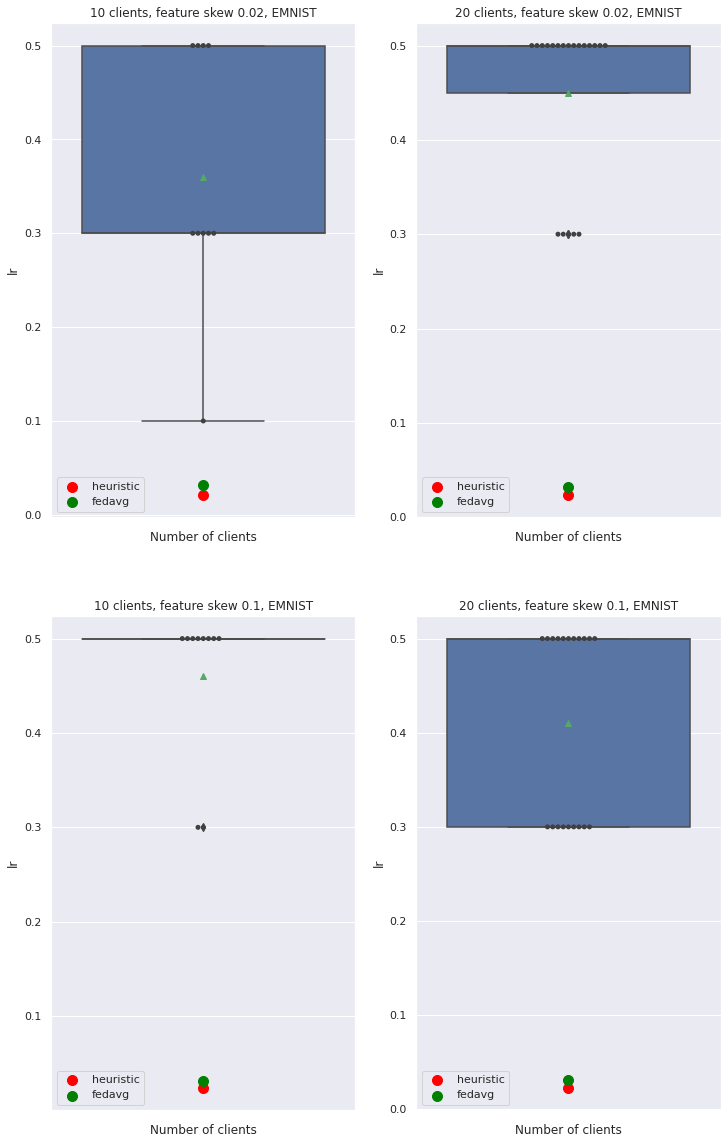

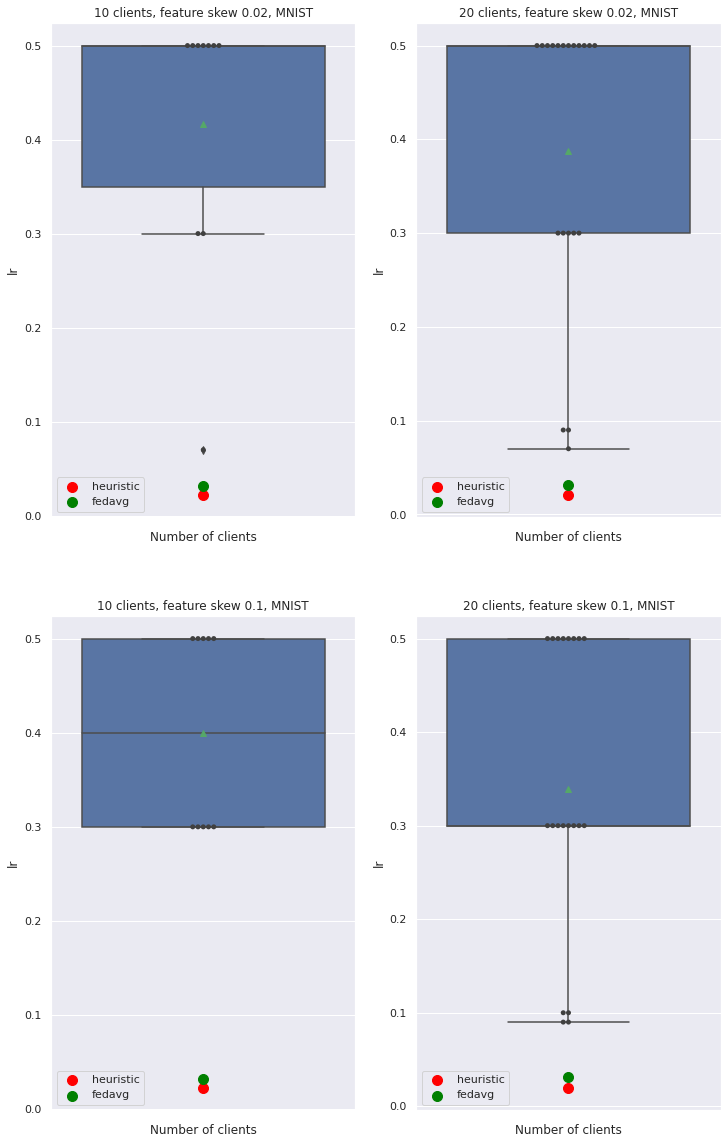

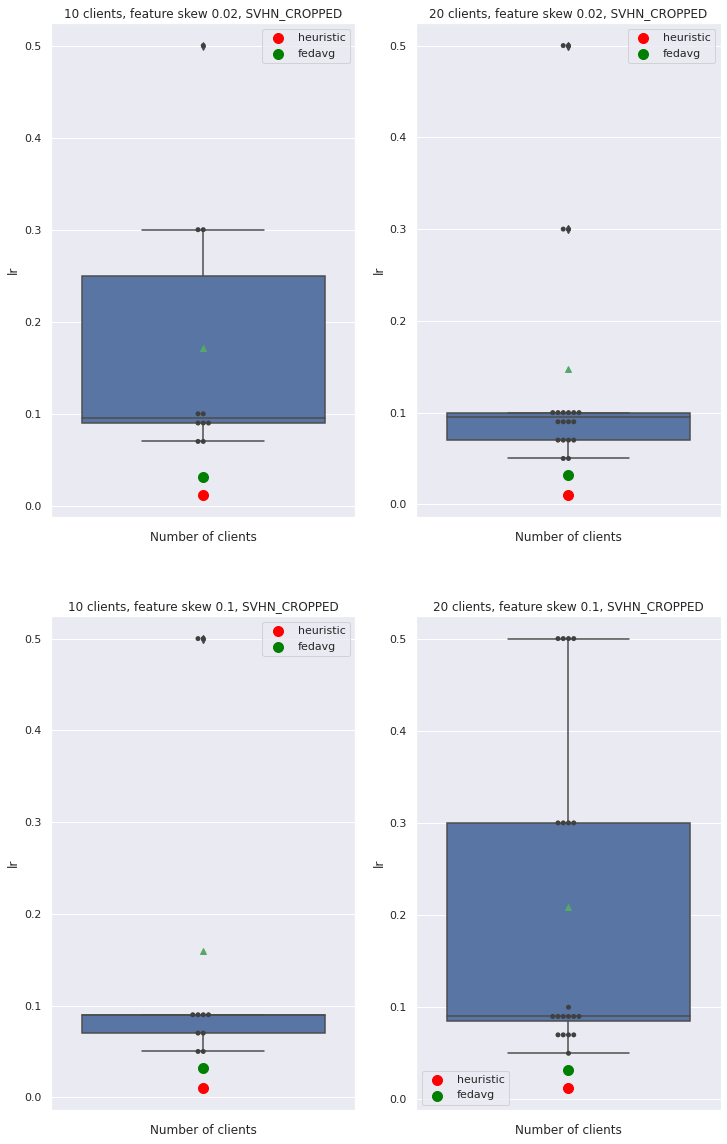

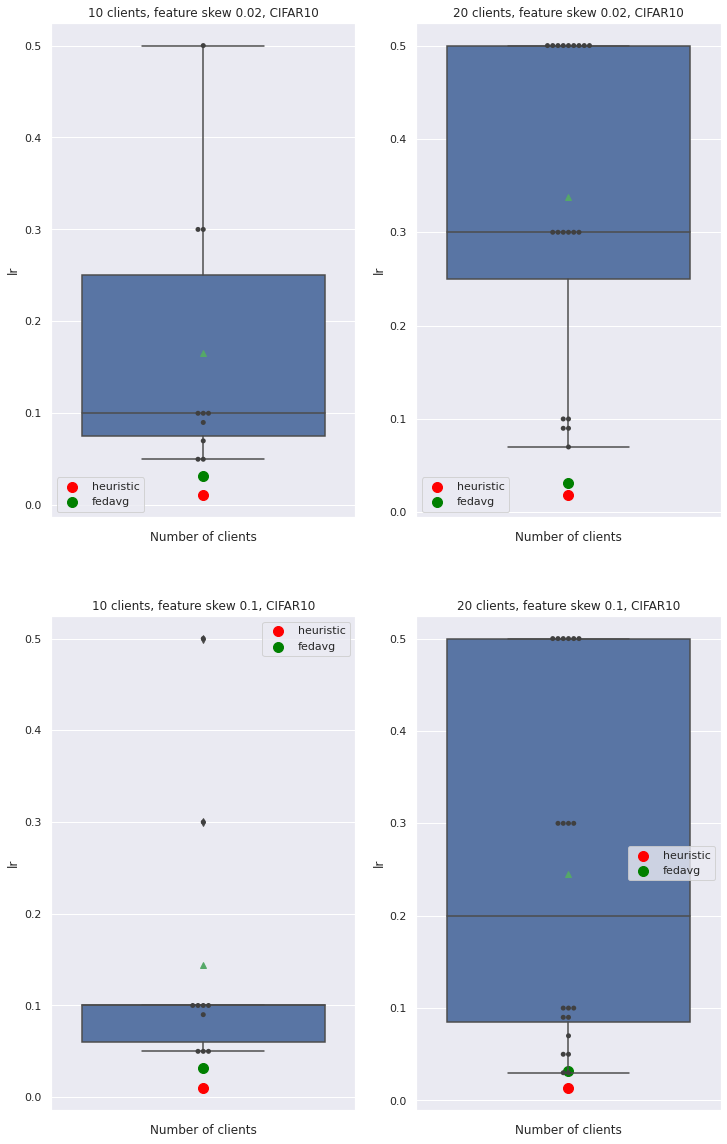

In [11]:
lr_feature_heuristic_aes = {}
lr_feature_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, FEATURE_SKEWS, NR_PARTIES, "lr", "feature")
    lr_feature_heuristic_aes = sum_dicts(lr_feature_heuristic_aes, heuristic_aes)
    lr_feature_baseline_aes = sum_dicts(lr_feature_baseline_aes, baseline_aes)

In [12]:
for v in ['v0']:
    print(f"Heuristic {v} MAE: {np.mean(lr_feature_heuristic_aes[v]):.3f} ± {np.std(lr_feature_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(lr_feature_baseline_aes['mean']):.3f} ± {np.std(lr_feature_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(lr_feature_baseline_aes['median']):.3f} ± {np.std(lr_feature_baseline_aes['median']):.3f}")

Heuristic v0 MAE: 0.014 ± 0.005
Mean MAE: 0.269 ± 0.115
Median MAE: 0.254 ± 0.171


Comments:
- Heuristic performs well, considerably better than baselines.
- Global learning rate consistently smaller than local learning rates found by clients.

### Feature skew - Batch Size Results

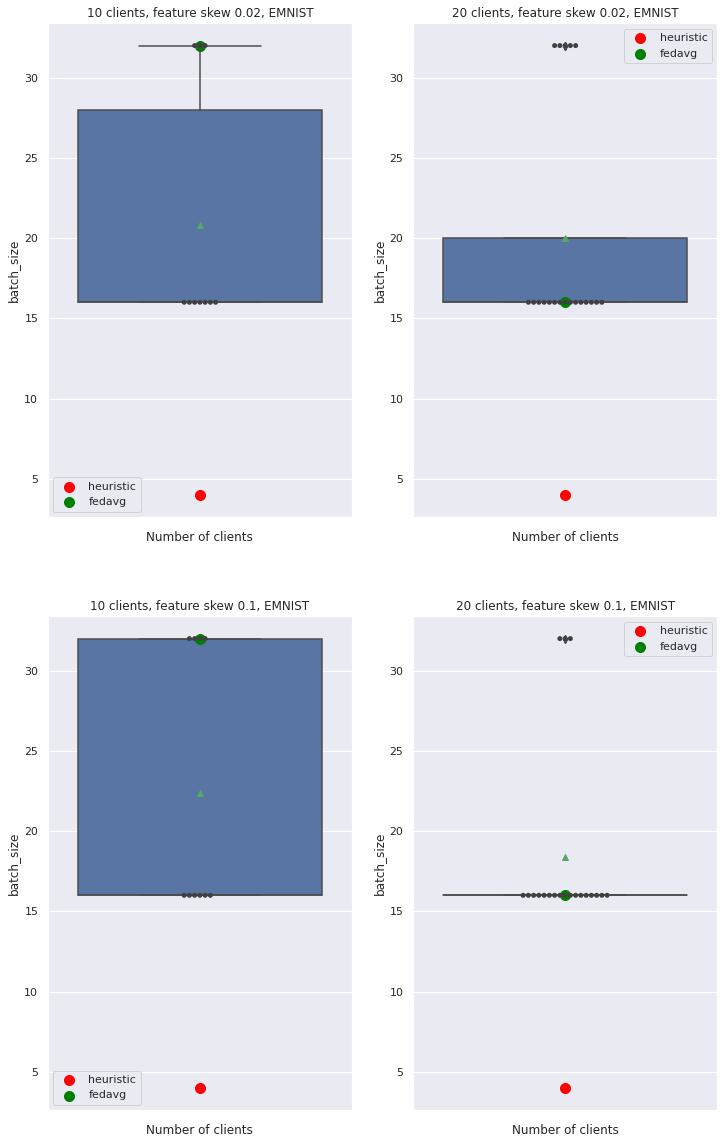

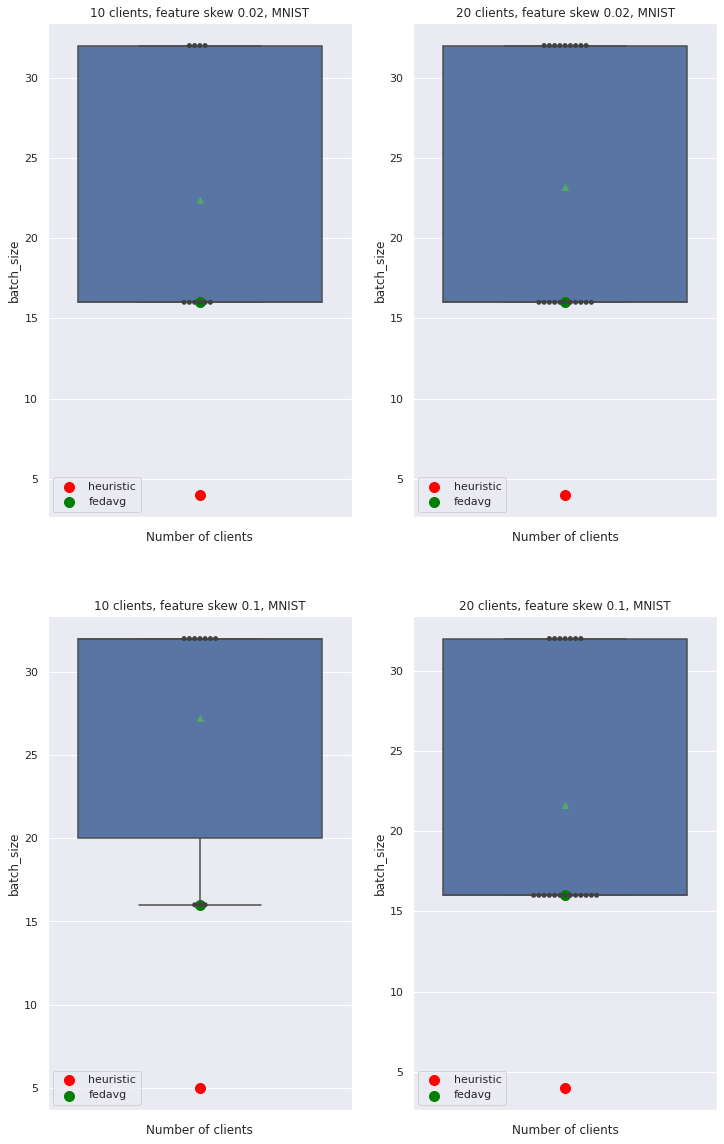

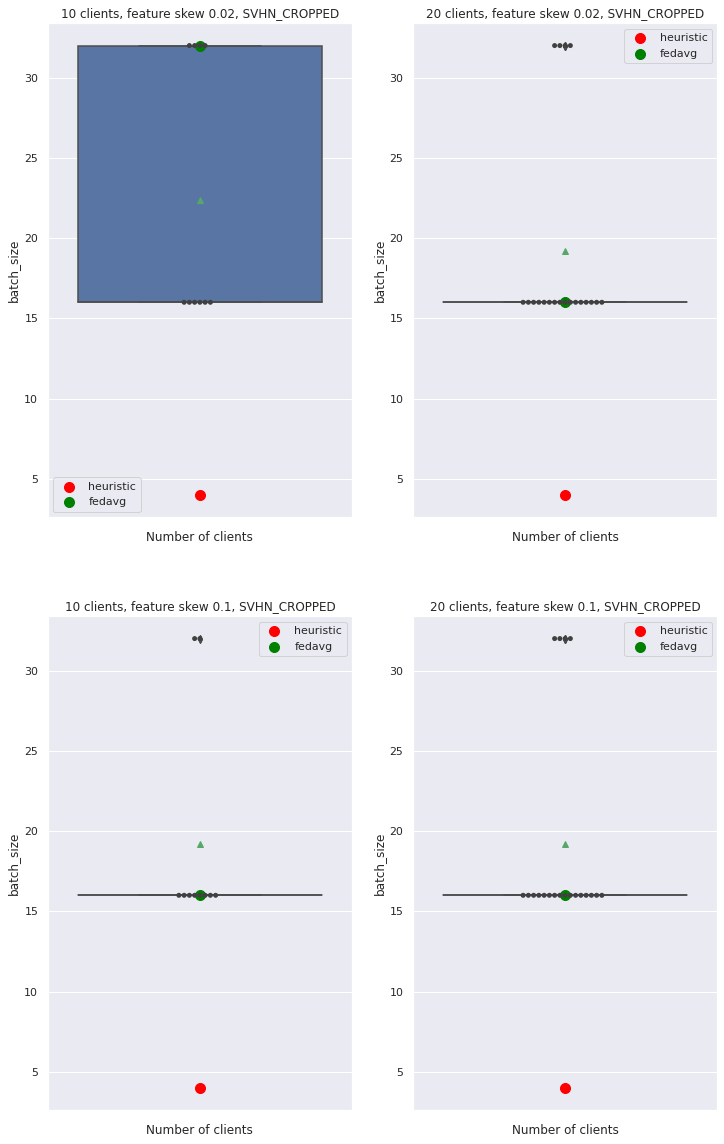

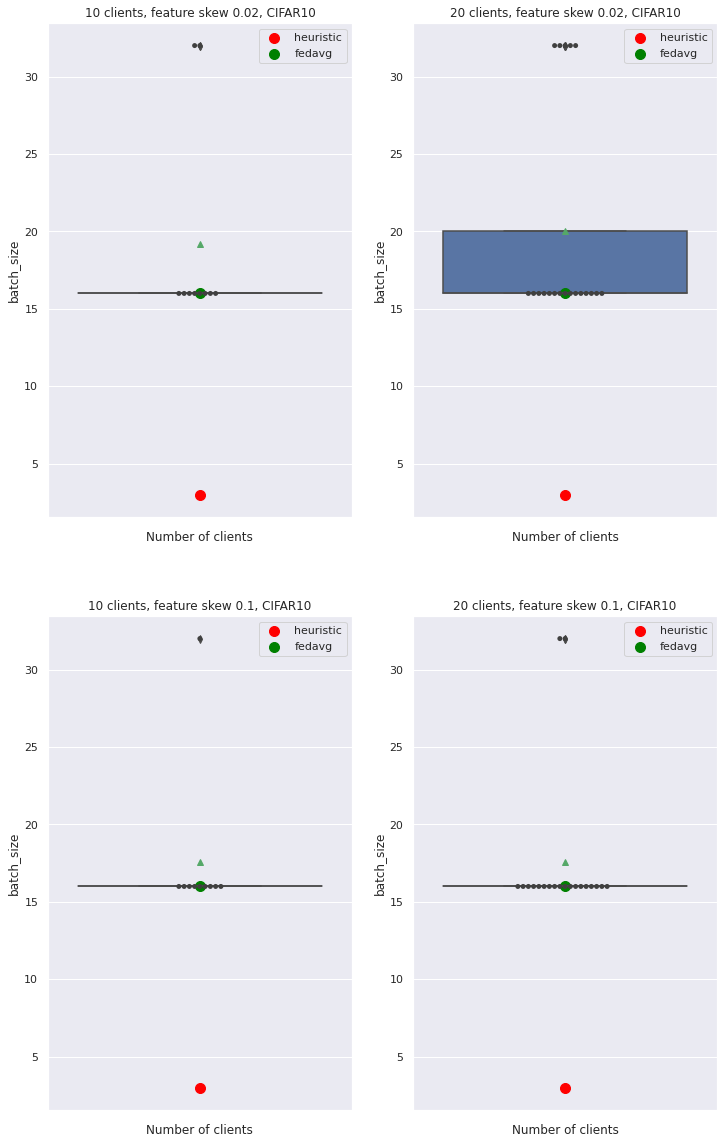

In [13]:
bs_feature_heuristic_aes = {}
bs_feature_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, FEATURE_SKEWS, NR_PARTIES, "batch_size", "feature")
    bs_feature_heuristic_aes = sum_dicts(bs_feature_heuristic_aes, heuristic_aes)
    bs_feature_baseline_aes = sum_dicts(bs_feature_baseline_aes, baseline_aes)

In [14]:
for v in ['v0', 'v1']:
    print(f"Heuristic {v} MAE: {np.mean(bs_feature_heuristic_aes[v]):.3f} ± {np.std(bs_feature_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(bs_feature_baseline_aes['mean']):.3f} ± {np.std(bs_feature_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(bs_feature_baseline_aes['median']):.3f} ± {np.std(bs_feature_baseline_aes['median']):.3f}")
print(f"Mode MAE: {np.mean(bs_feature_baseline_aes['mode']):.3f} ± {np.std(bs_feature_baseline_aes['mode']):.3f}")

Heuristic v0 MAE: 15.188 ± 6.177
Heuristic v1 MAE: 15.188 ± 6.177
Mean MAE: 14.938 ± 6.280
Median MAE: 14.938 ± 6.280
Mode MAE: 14.938 ± 6.280


Comments:
- Mean between two batch sizes does not make sense, since the fedavg batch size is discrete
    - solution: project aggregation result to the closest power of two
- Batch size heuristic slightly worse performance than baseline.
- In general, heuristic tends to underestimate best batch size.
- Accuracy might be more suitable metric.

### Feature skew - Momentum Results

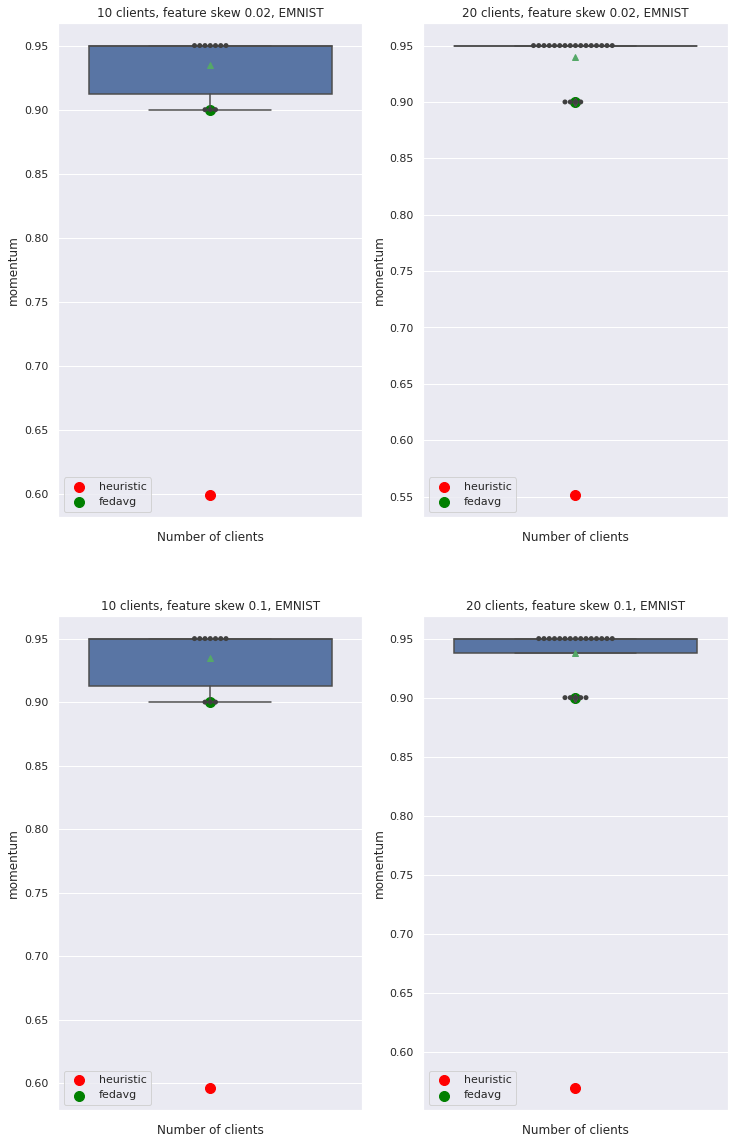

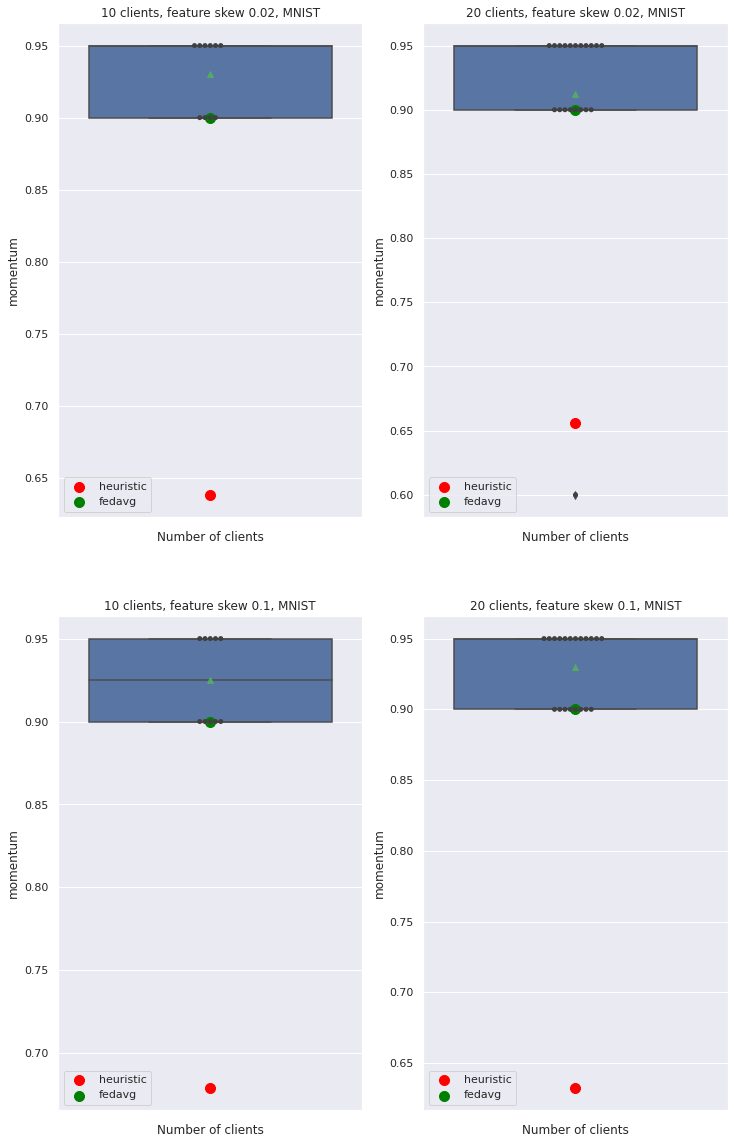

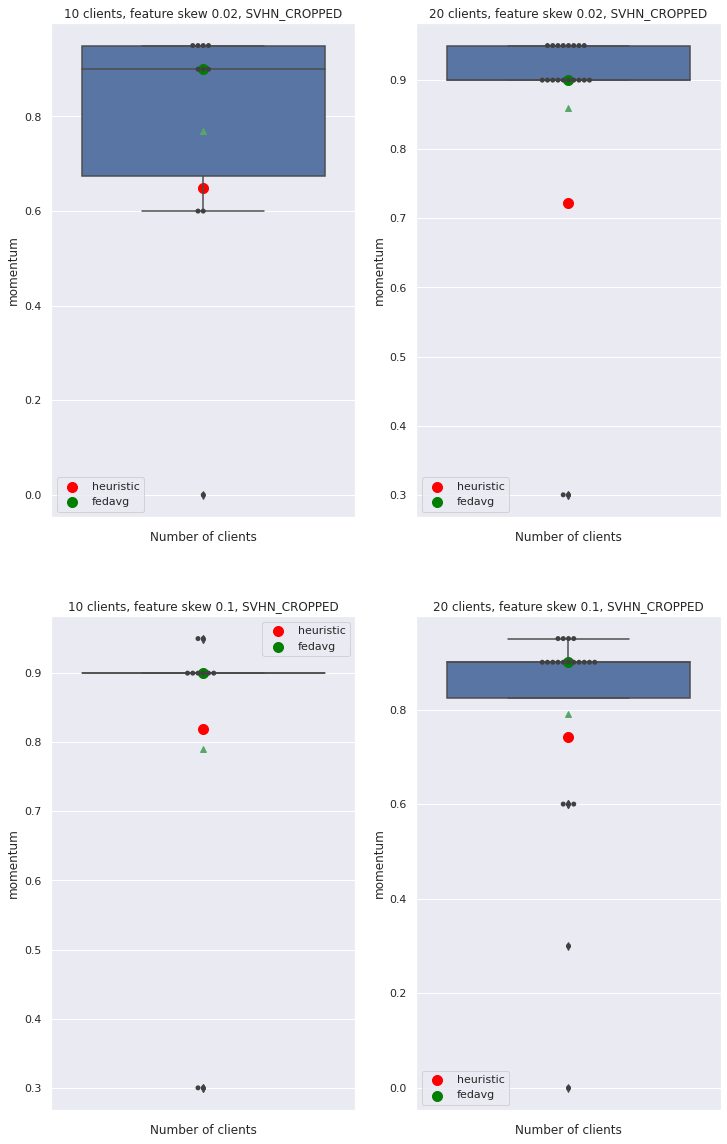

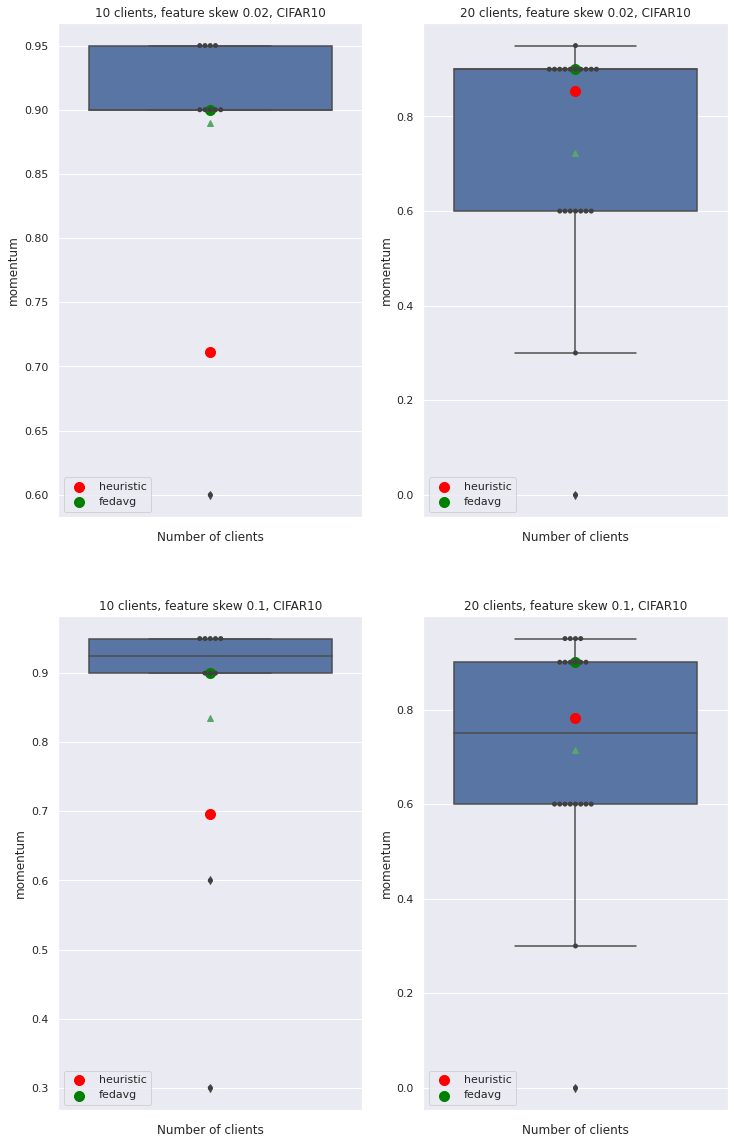

In [15]:
mom_feature_heuristic_aes = {}
mom_feature_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, FEATURE_SKEWS, NR_PARTIES, "momentum", "feature")
    mom_feature_heuristic_aes = sum_dicts(mom_feature_heuristic_aes, heuristic_aes)
    mom_feature_baseline_aes = sum_dicts(mom_feature_baseline_aes, baseline_aes)

In [16]:
for v in ['v0', 'v1']:
    print(
        f"Heuristic {v} MAE: {np.mean(mom_feature_heuristic_aes[v]):.3f} ± {np.std(mom_feature_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(mom_feature_baseline_aes['mean']):.3f} ± {np.std(mom_feature_baseline_aes['mean']):.3f}")
print(
    f"Median MAE: {np.mean(mom_feature_baseline_aes['median']):.3f} ± {np.std(mom_feature_baseline_aes['median']):.3f}")

Heuristic v0 MAE: 0.219 ± 0.085
Heuristic v1 MAE: 0.217 ± 0.135
Mean MAE: 0.067 ± 0.055
Median MAE: 0.034 ± 0.037


Comments:
- Heuristic performs very badly, tends to underestimate global momentum.
- Median gives best performance, mean is also good.
- Best fedavg momentum tends to be in the 75% percentile of clients' momentums.


## Label skew

## Label skew - Learning Rate Results

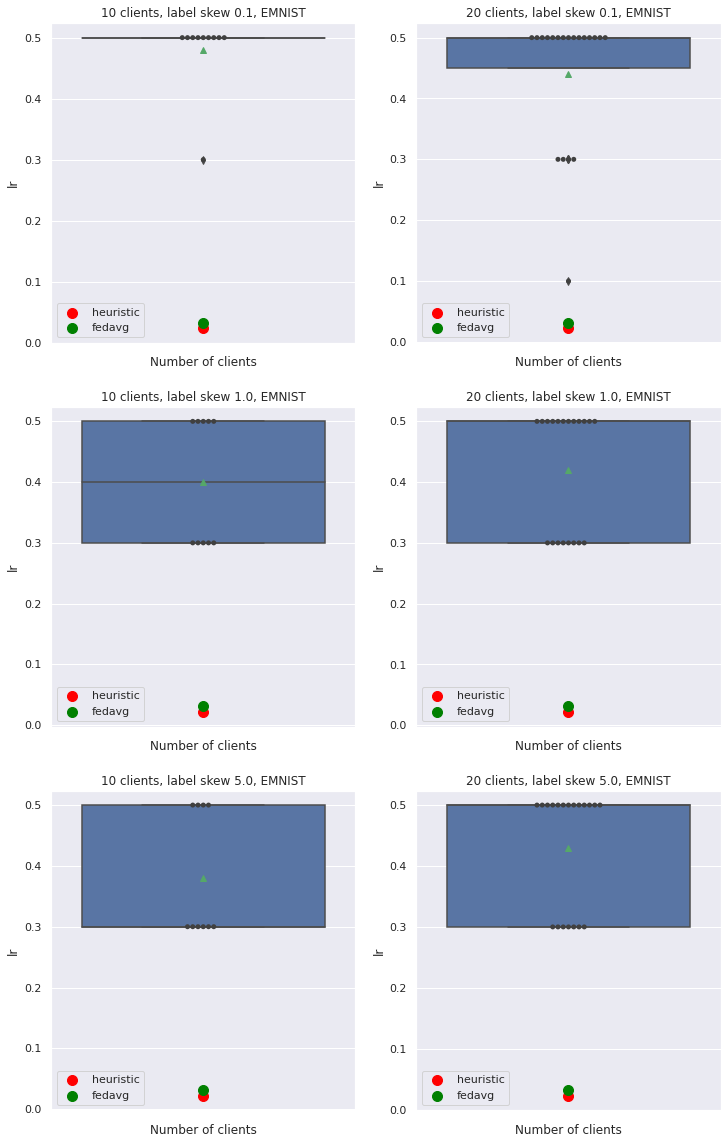

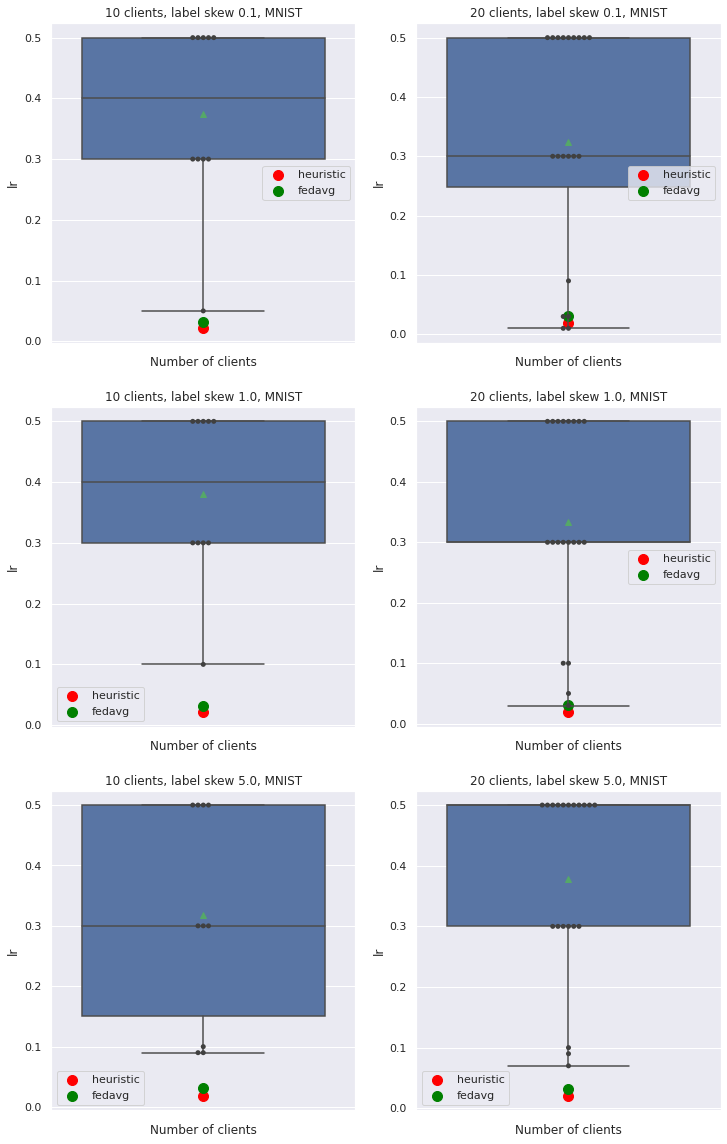

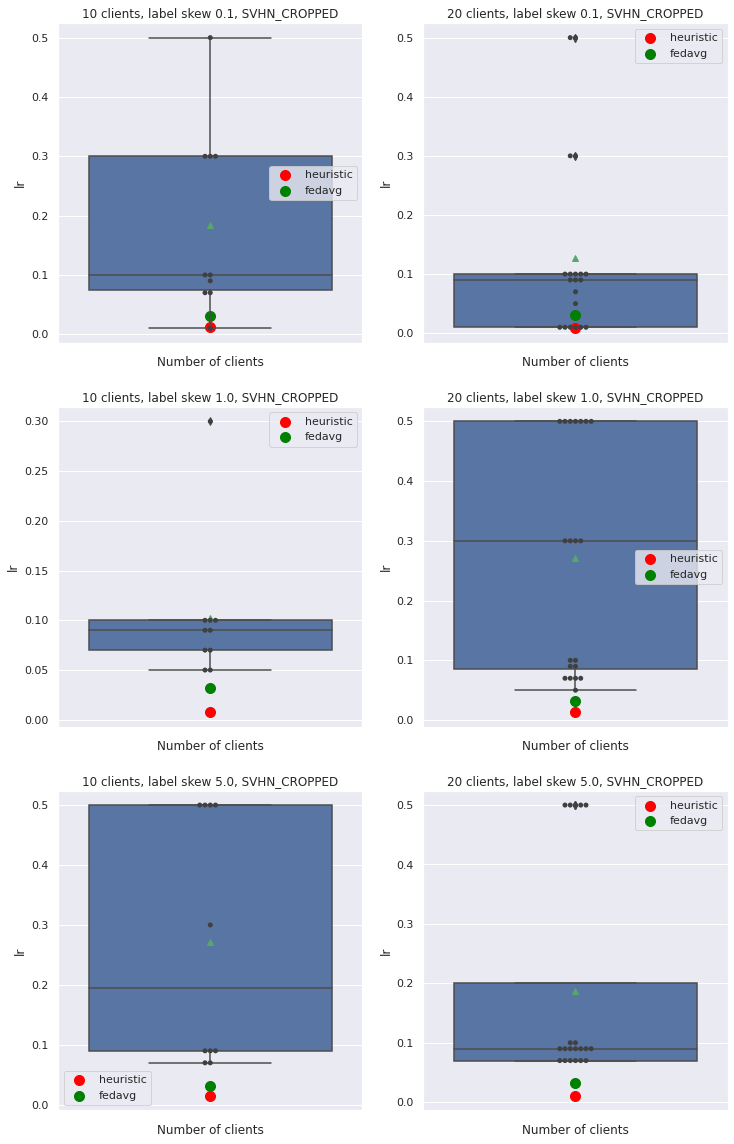

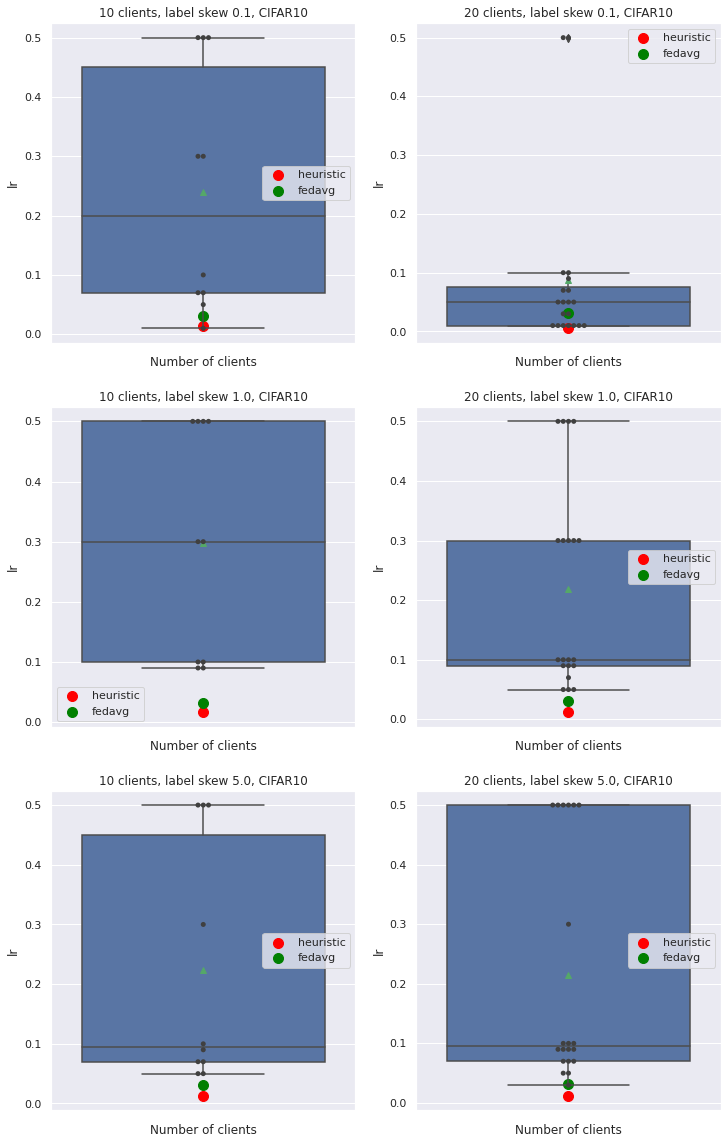

In [17]:
lr_label_heuristic_aes = {}
lr_label_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, LABEL_SKEWS, NR_PARTIES, "lr", "label")
    lr_label_heuristic_aes = sum_dicts(lr_label_heuristic_aes, heuristic_aes)
    lr_label_baseline_aes = sum_dicts(lr_label_baseline_aes, baseline_aes)

In [18]:
for v in ['v0']:
    print(f"Heuristic {v} MAE: {np.mean(lr_label_heuristic_aes[v]):.3f} ± {np.std(lr_label_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(lr_label_baseline_aes['mean']):.3f} ± {np.std(lr_label_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(lr_label_baseline_aes['median']):.3f} ± {np.std(lr_label_baseline_aes['median']):.3f}")

Heuristic v0 MAE: 0.015 ± 0.005
Mean MAE: 0.264 ± 0.109
Median MAE: 0.244 ± 0.157


Comments:
- Heuristic performs well, considerably better than baselines.
- Global learning rate consistently smaller than local learning rates found by clients.

### Label skew - Batch Size Results

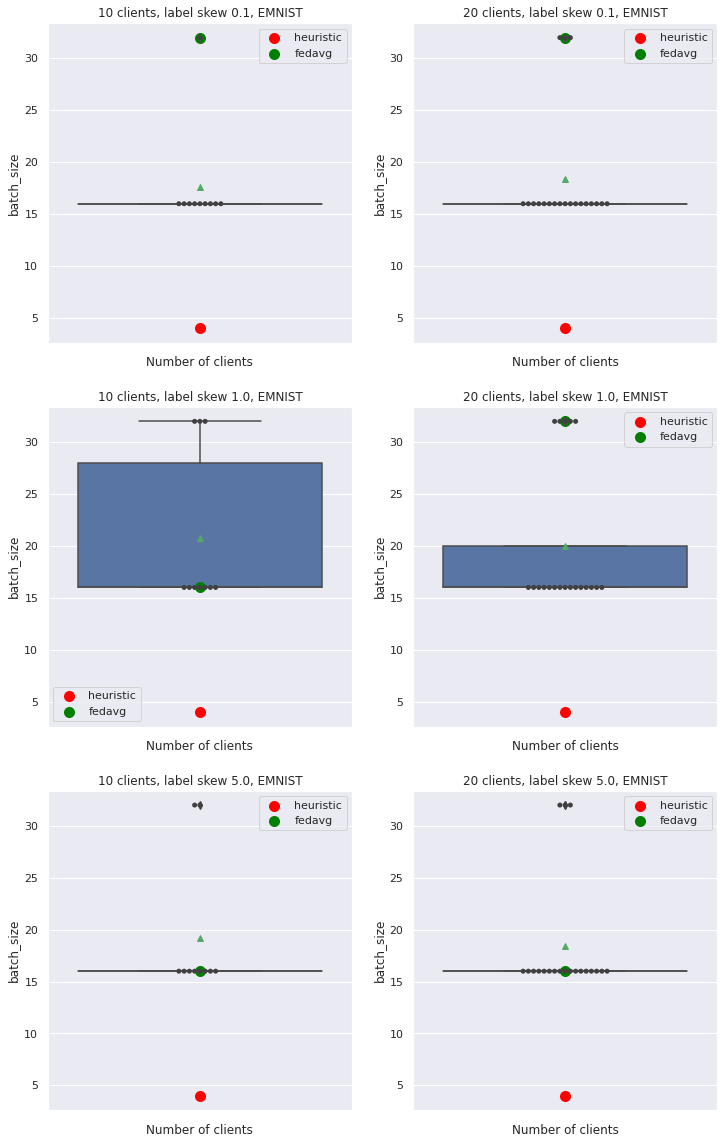

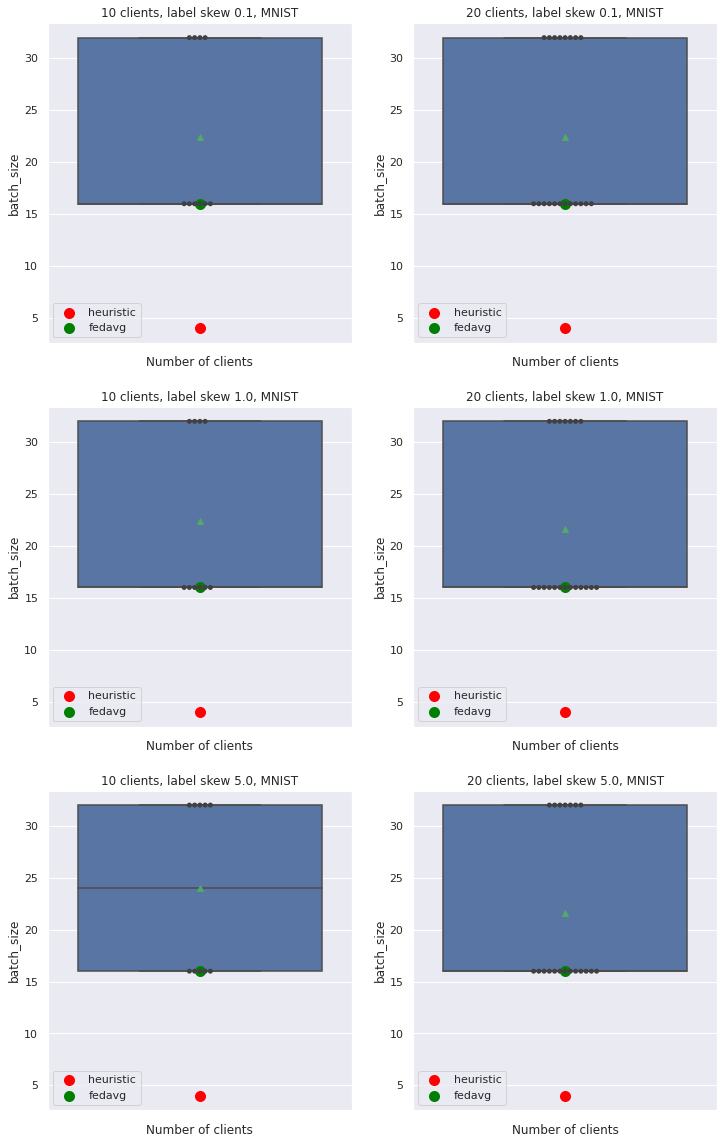

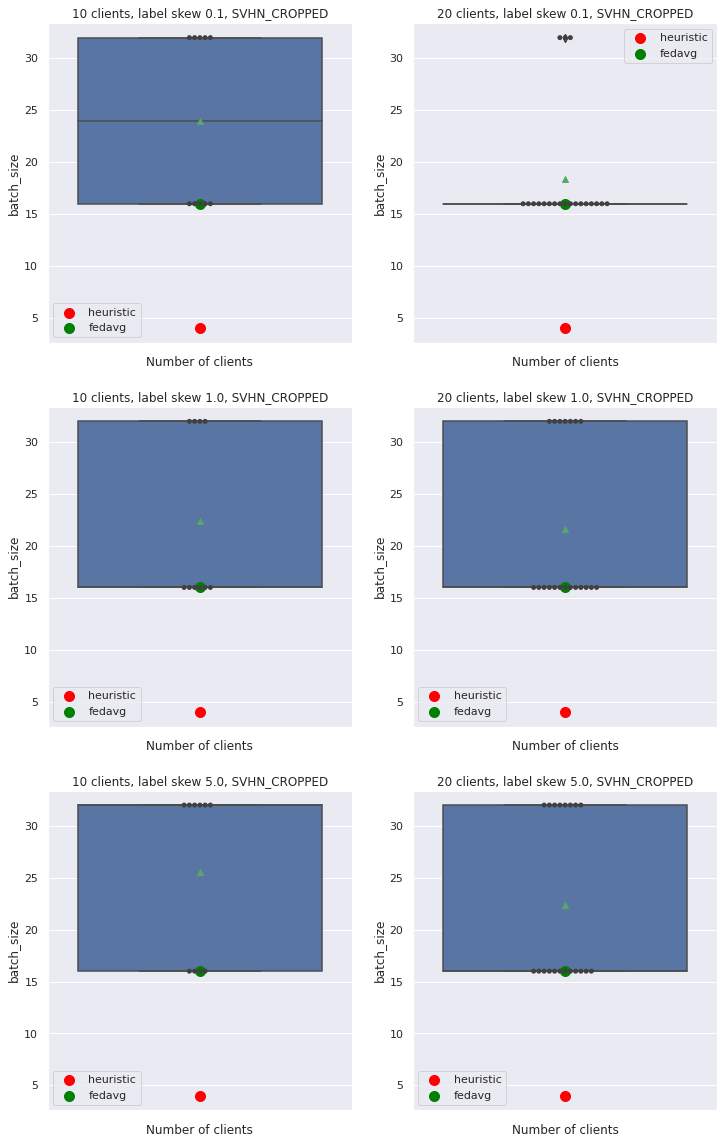

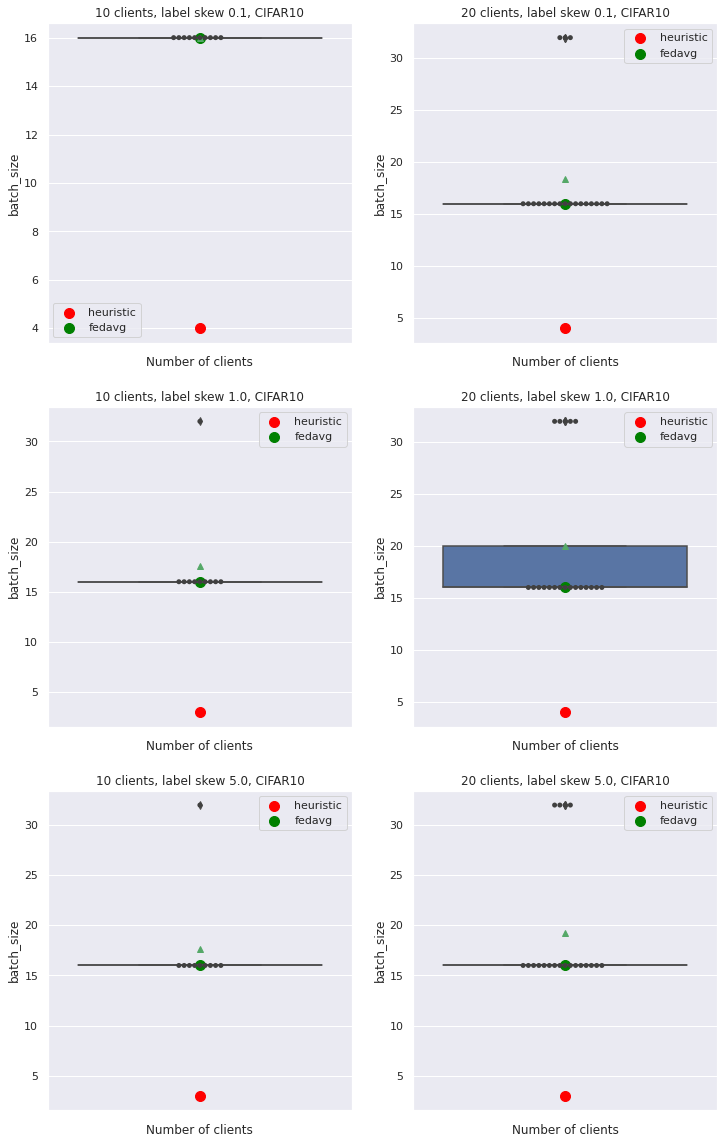

In [19]:
bs_label_heuristic_aes = {}
bs_label_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, LABEL_SKEWS, NR_PARTIES, "batch_size", "label")
    bs_label_heuristic_aes = sum_dicts(bs_label_heuristic_aes, heuristic_aes)
    bs_label_baseline_aes = sum_dicts(bs_label_baseline_aes, baseline_aes)

In [20]:
for v in ['v0']:
    print(f"Heuristic {v} MAE: {np.mean(bs_label_heuristic_aes[v]):.3f} ± {np.std(bs_label_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(bs_label_baseline_aes['mean']):.3f} ± {np.std(bs_label_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(bs_label_baseline_aes['median']):.3f} ± {np.std(bs_label_baseline_aes['median']):.3f}")
print(f"Mode MAE: {np.mean(bs_label_baseline_aes['mode']):.3f} ± {np.std(bs_label_baseline_aes['mode']):.3f}")

Heuristic v0 MAE: 14.125 ± 5.254
Mean MAE: 13.958 ± 5.311
Median MAE: 13.958 ± 5.311
Mode MAE: 13.917 ± 5.330


Comments:
- Mean between two batch sizes does not make sense, since the fedavg batch size is discrete
    - solution: project aggregation result to the closest power of two
- Batch size heuristic slightly worse performance than baseline.
- In general, heuristic tends to underestimate best batch size.
- Accuracy might be more suitable metric.

### Label skew - Momentum Results

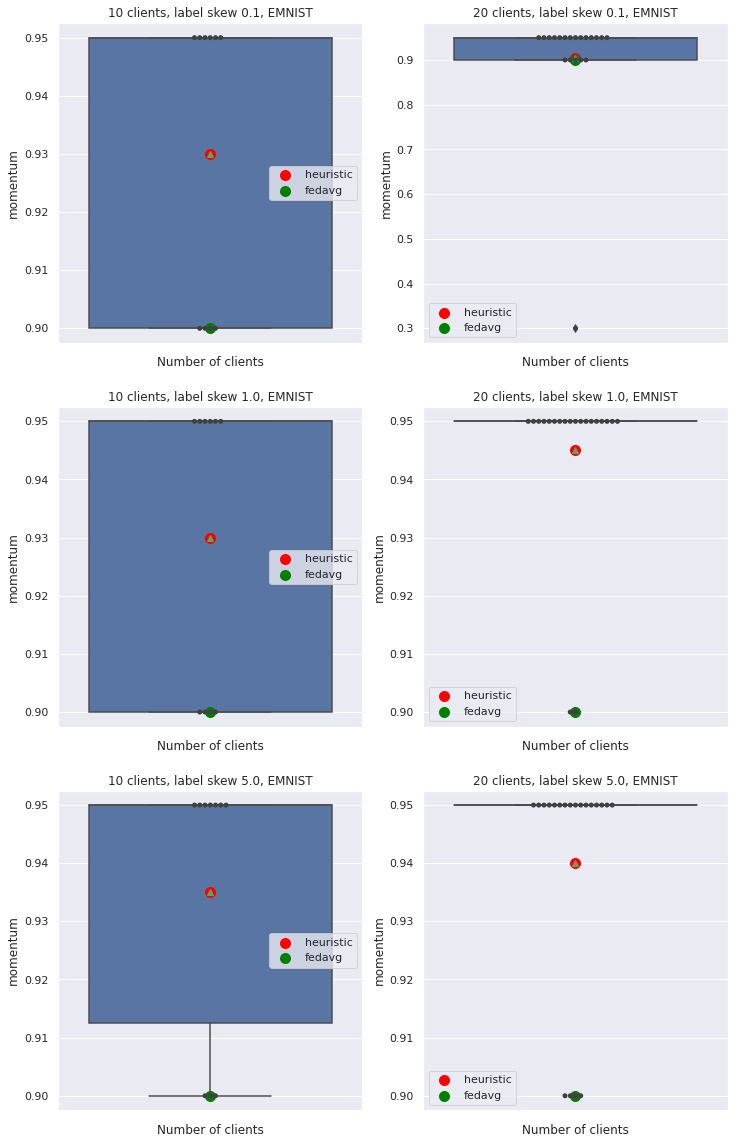

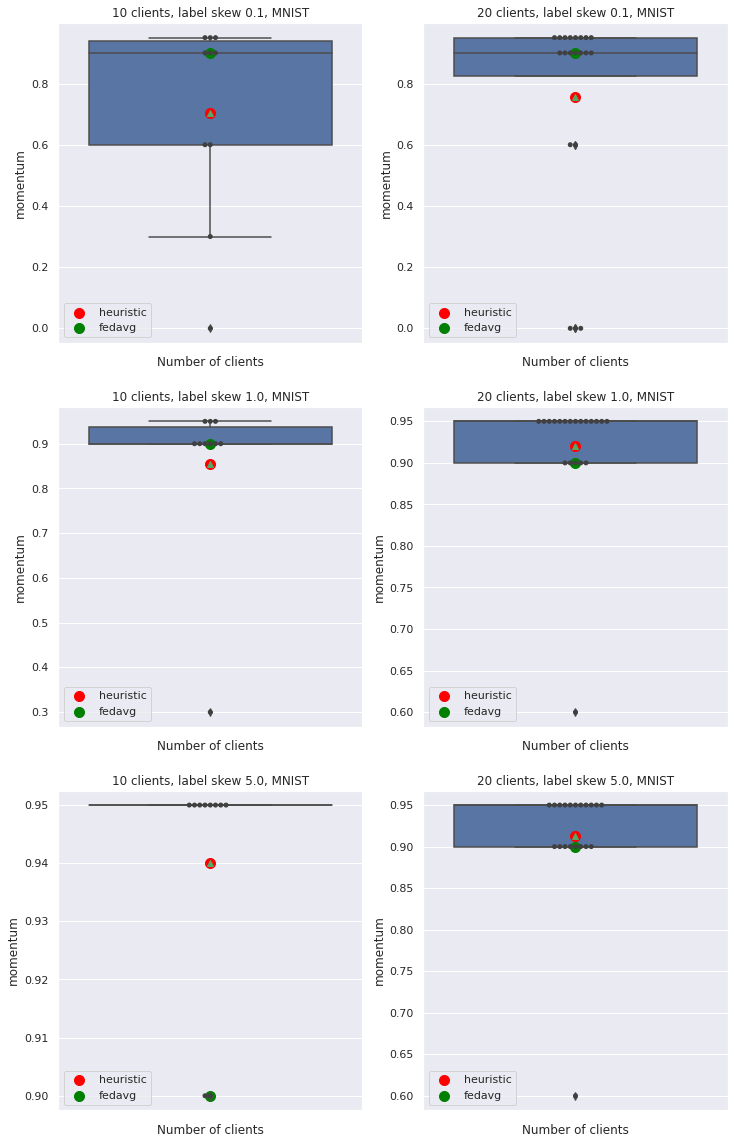

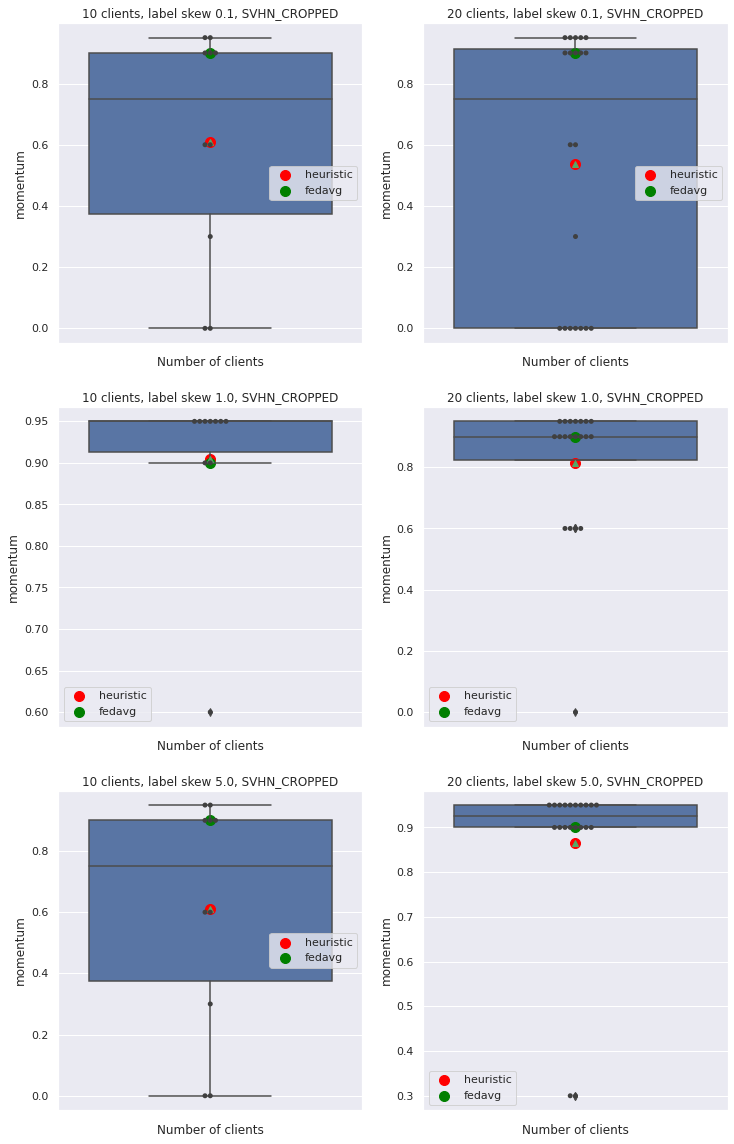

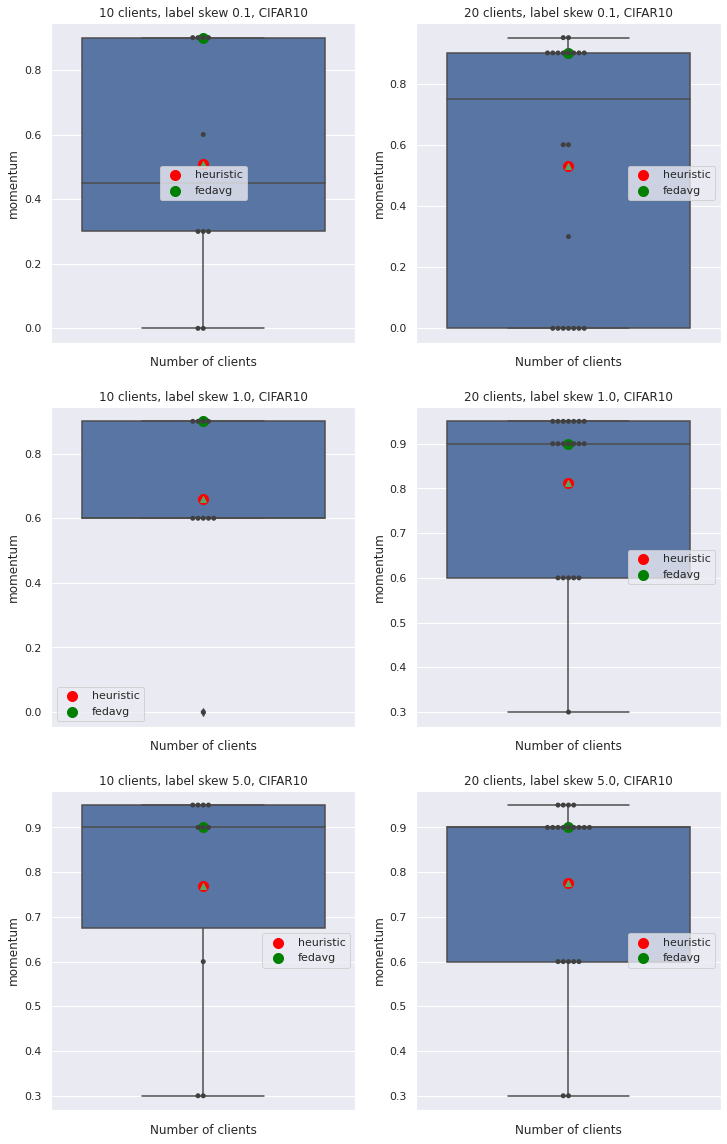

In [21]:
mom_label_heuristic_aes = {}
mom_label_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, LABEL_SKEWS, NR_PARTIES, "momentum", "label")
    mom_label_heuristic_aes = sum_dicts(mom_label_heuristic_aes, heuristic_aes)
    mom_label_baseline_aes = sum_dicts(mom_label_baseline_aes, baseline_aes)

In [22]:
for v in ['v0']:
    print(f"Heuristic MAE: {np.mean(mom_label_heuristic_aes[v]):.3f} ± {np.std(mom_label_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(mom_label_baseline_aes['mean']):.3f} ± {np.std(mom_label_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(mom_label_baseline_aes['median']):.3f} ± {np.std(mom_label_baseline_aes['median']):.3f}")

Heuristic MAE: 0.127 ± 0.125
Mean MAE: 0.127 ± 0.125
Median MAE: 0.078 ± 0.104


Comments:
- Heuristic is equal to mean baseline.
- Median performs slightly better than mean.

## Quantity skew

### Quantity skew - Learning Rate Results

File for client 16 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 17 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 18 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 8 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 9 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 18 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 9 in MNIST ('1.0', 10, 'qty') does not exist.
File for client 17 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 18 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 9 in MNIST ('2.0', 10, 'qty') does not exist.
File for client 18 in MNIST ('2.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('2.0', 20, 'qty') does not exist.


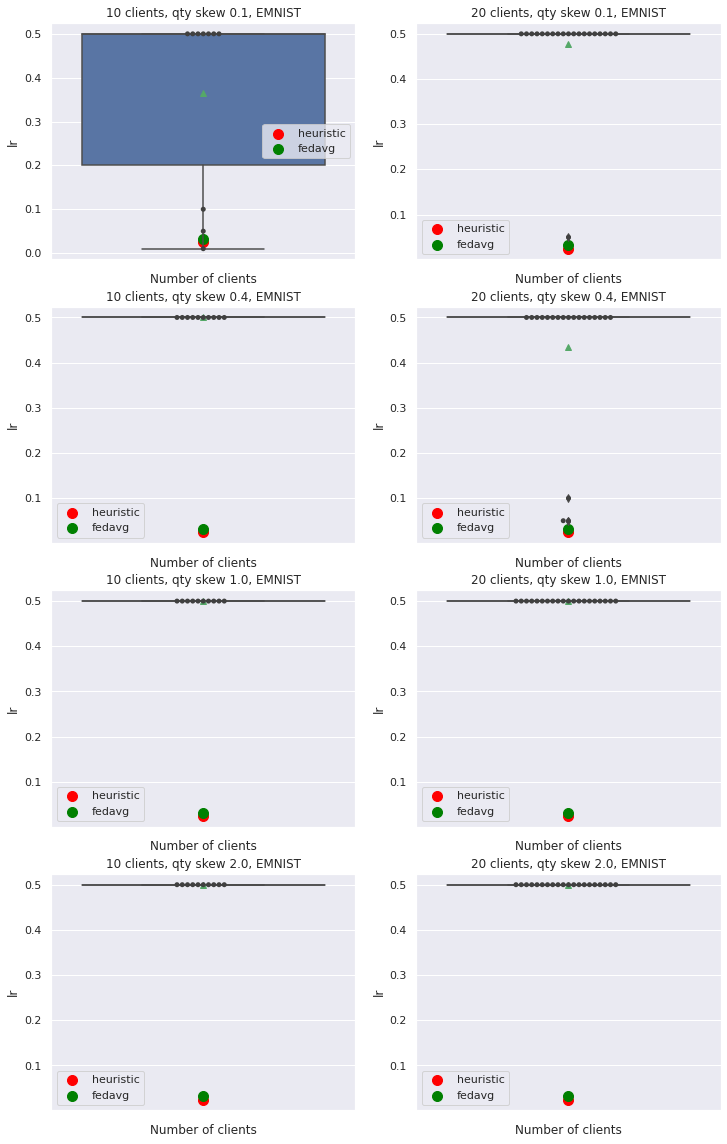

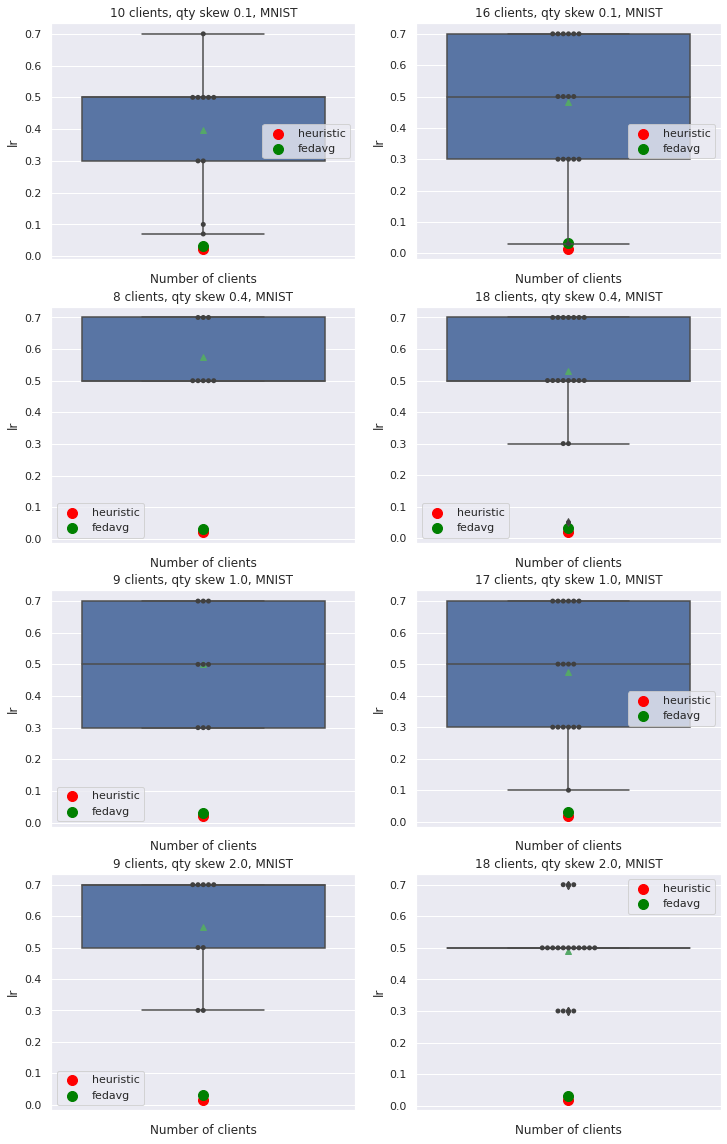

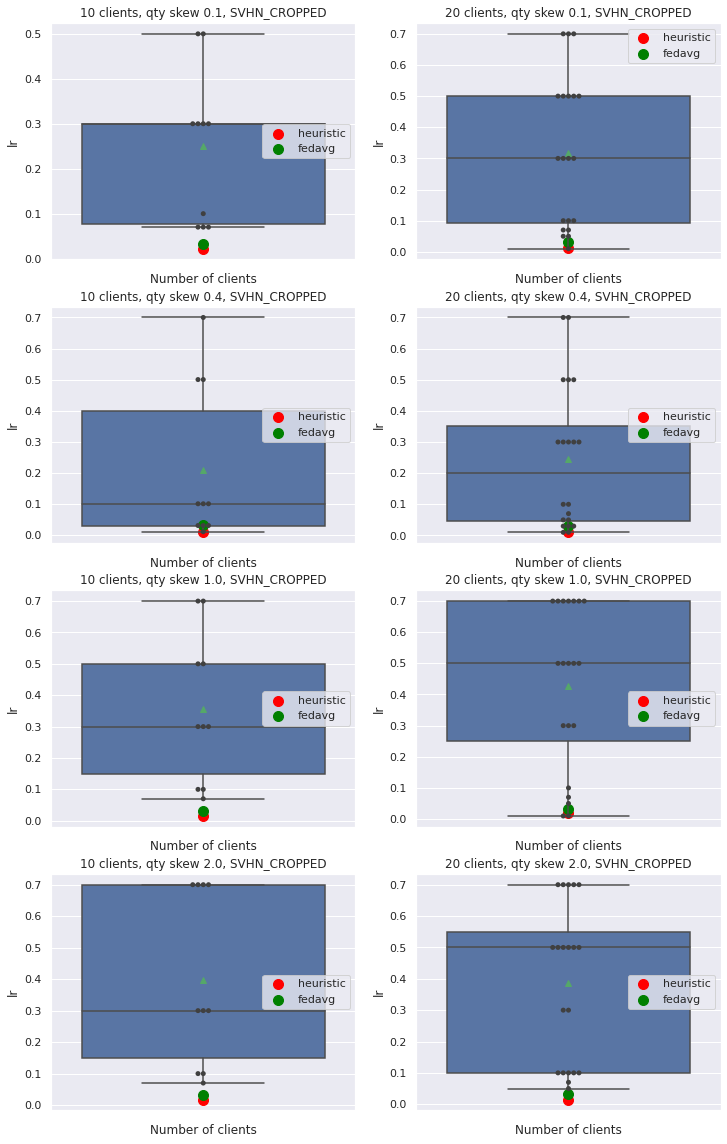

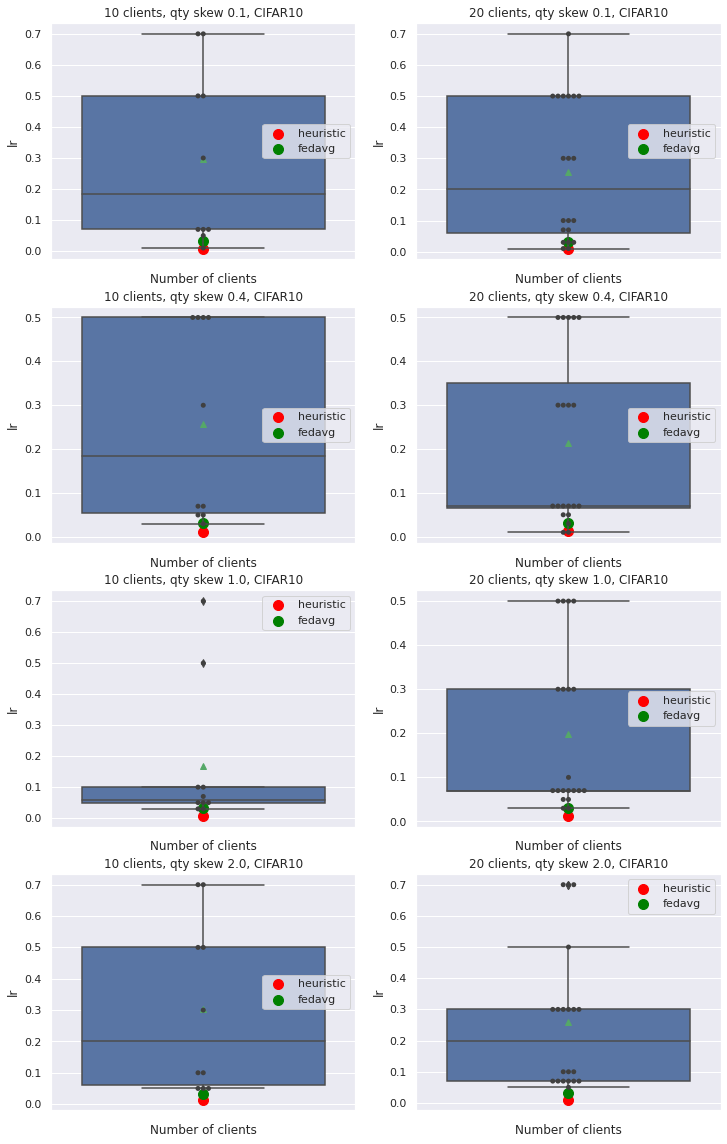

In [23]:
lr_qty_heuristic_aes = {}
lr_qty_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, QTY_SKEWS, NR_PARTIES, "lr", "qty")
    lr_qty_heuristic_aes = sum_dicts(lr_qty_heuristic_aes, heuristic_aes)
    lr_qty_baseline_aes = sum_dicts(lr_qty_baseline_aes, baseline_aes)

In [24]:
for v in ['v0']:
    print(f"Heuristic {v} MAE: {np.mean(lr_qty_heuristic_aes[v]):.3f} ± {np.std(lr_qty_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(lr_qty_baseline_aes['mean']):.3f} ± {np.std(lr_qty_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(lr_qty_baseline_aes['median']):.3f} ± {np.std(lr_qty_baseline_aes['median']):.3f}")

Heuristic v0 MAE: 0.014 ± 0.006
Mean MAE: 0.354 ± 0.120
Median MAE: 0.339 ± 0.172


Comments:
- Heuristic performs well, considerably better than baselines.
- Global learning rate consistently smaller than local learning rates found by clients.

### Quantity skew - Batch Size Results

File for client 16 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 17 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 18 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 8 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 9 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 18 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 9 in MNIST ('1.0', 10, 'qty') does not exist.
File for client 17 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 18 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 9 in MNIST ('2.0', 10, 'qty') does not exist.
File for client 18 in MNIST ('2.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('2.0', 20, 'qty') does not exist.


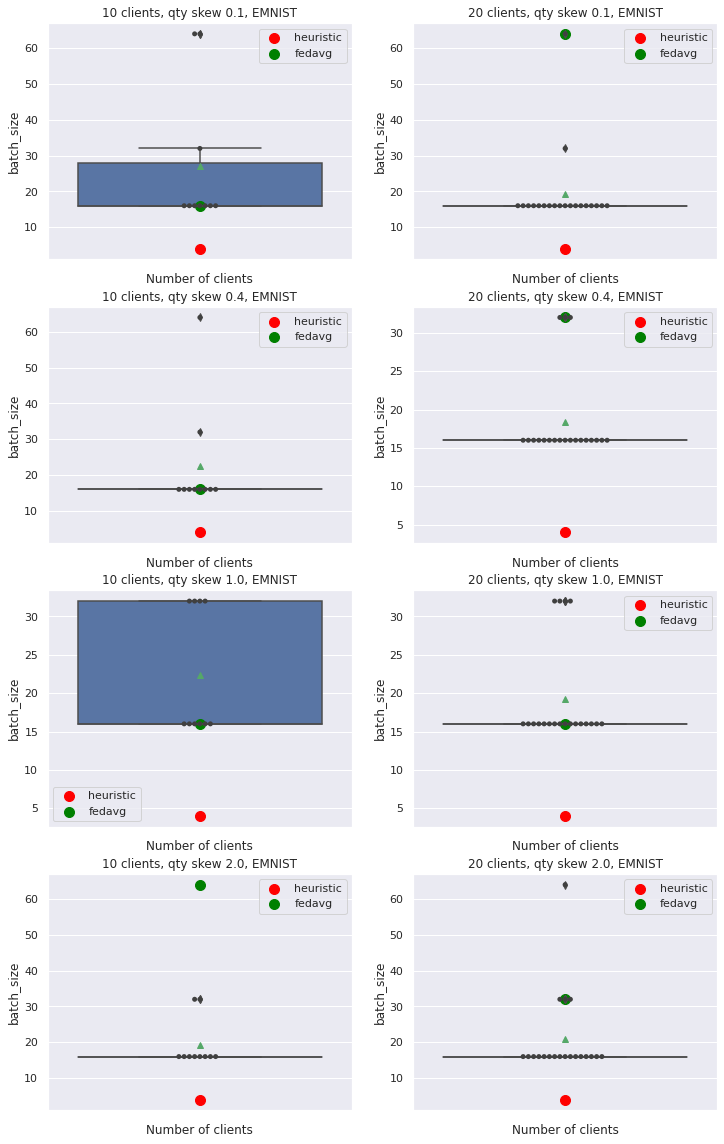

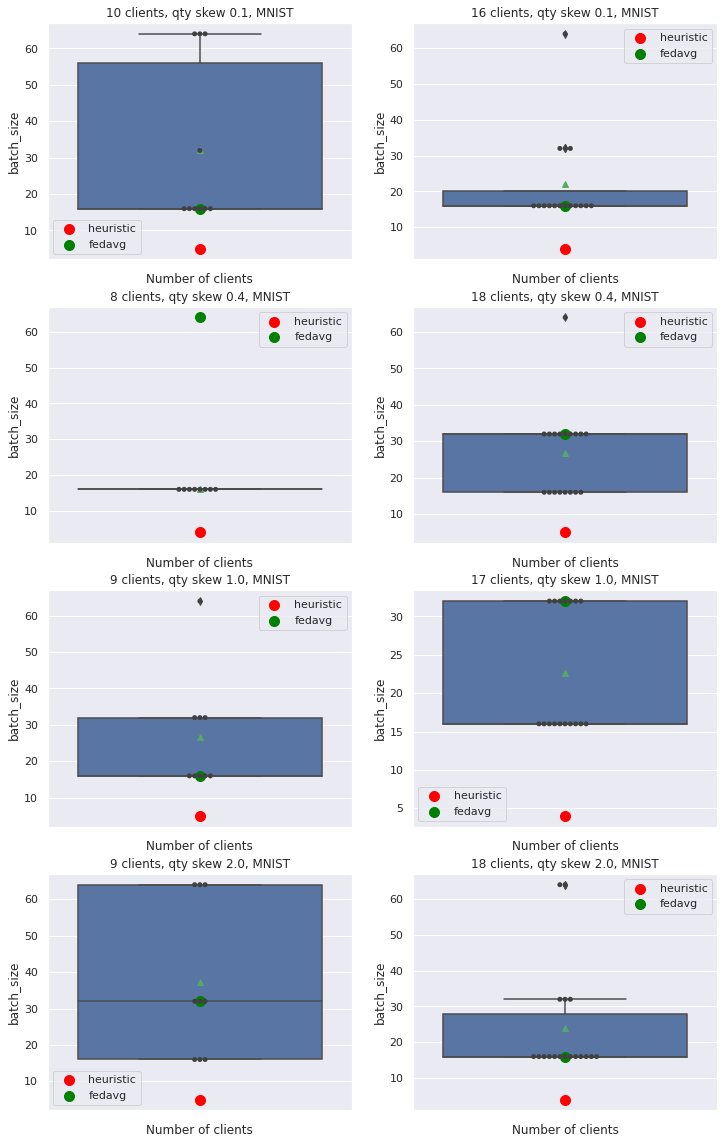

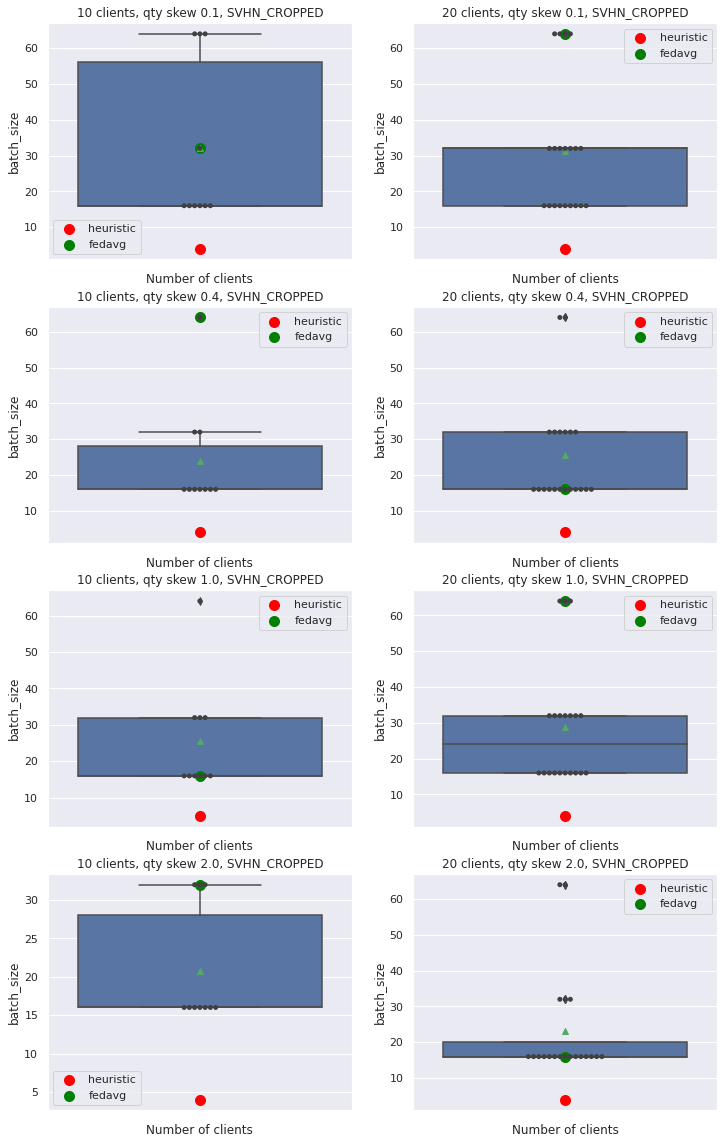

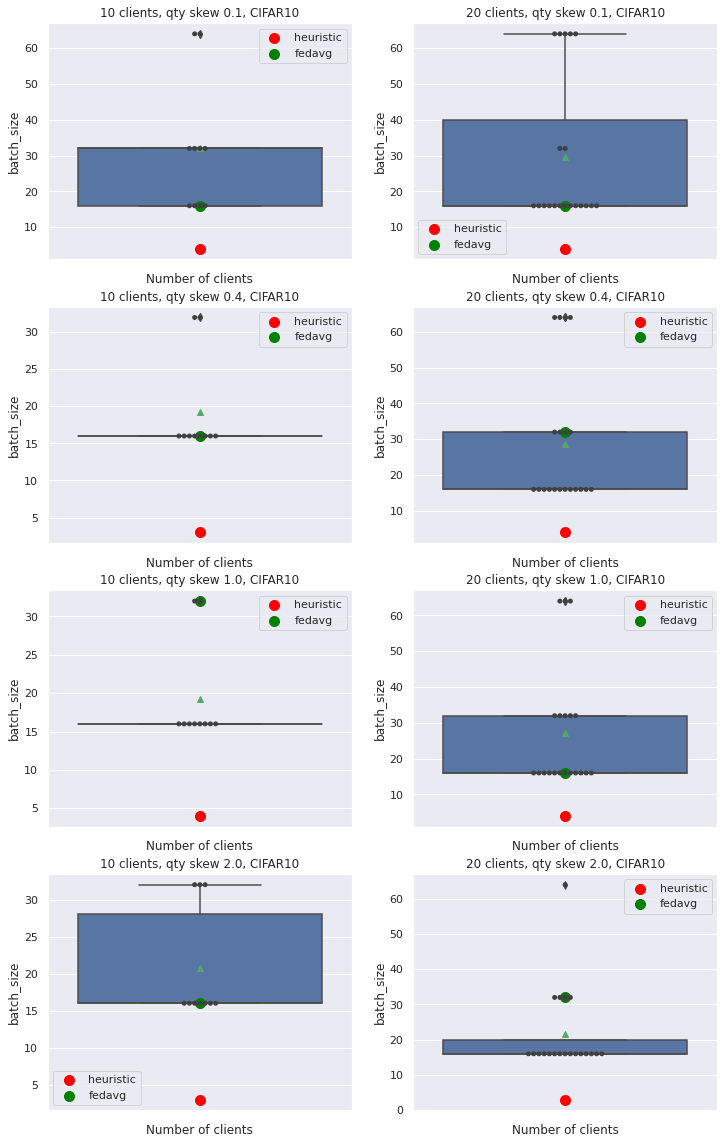

In [25]:
bs_qty_heuristic_aes = {}
bs_qty_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, QTY_SKEWS, NR_PARTIES, "batch_size", "qty")
    bs_qty_heuristic_aes = sum_dicts(bs_qty_heuristic_aes, heuristic_aes)
    bs_qty_baseline_aes = sum_dicts(bs_qty_baseline_aes, baseline_aes)

In [26]:
for v in ['v0']:
    print(f"Heuristic MAE: {np.mean(bs_qty_heuristic_aes[v]):.3f} ± {np.std(bs_qty_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(bs_qty_baseline_aes['mean']):.3f} ± {np.std(bs_qty_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(bs_qty_baseline_aes['median']):.3f} ± {np.std(bs_qty_baseline_aes['median']):.3f}")
print(f"Mode MAE: {np.mean(bs_qty_baseline_aes['mode']):.3f} ± {np.std(bs_qty_baseline_aes['mode']):.3f}")

Heuristic MAE: 25.938 ± 17.804
Mean MAE: 25.562 ± 17.846
Median MAE: 25.875 ± 17.737
Mode MAE: 25.969 ± 17.774


Comments:
- Batch size heuristic very bad, tends to underestimate.

### Quantity skew - Momentum Results

File for client 16 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 17 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 18 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.1', 20, 'qty') does not exist.
File for client 8 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 9 in MNIST ('0.4', 10, 'qty') does not exist.
File for client 18 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 19 in MNIST ('0.4', 20, 'qty') does not exist.
File for client 9 in MNIST ('1.0', 10, 'qty') does not exist.
File for client 17 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 18 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('1.0', 20, 'qty') does not exist.
File for client 9 in MNIST ('2.0', 10, 'qty') does not exist.
File for client 18 in MNIST ('2.0', 20, 'qty') does not exist.
File for client 19 in MNIST ('2.0', 20, 'qty') does not exist.


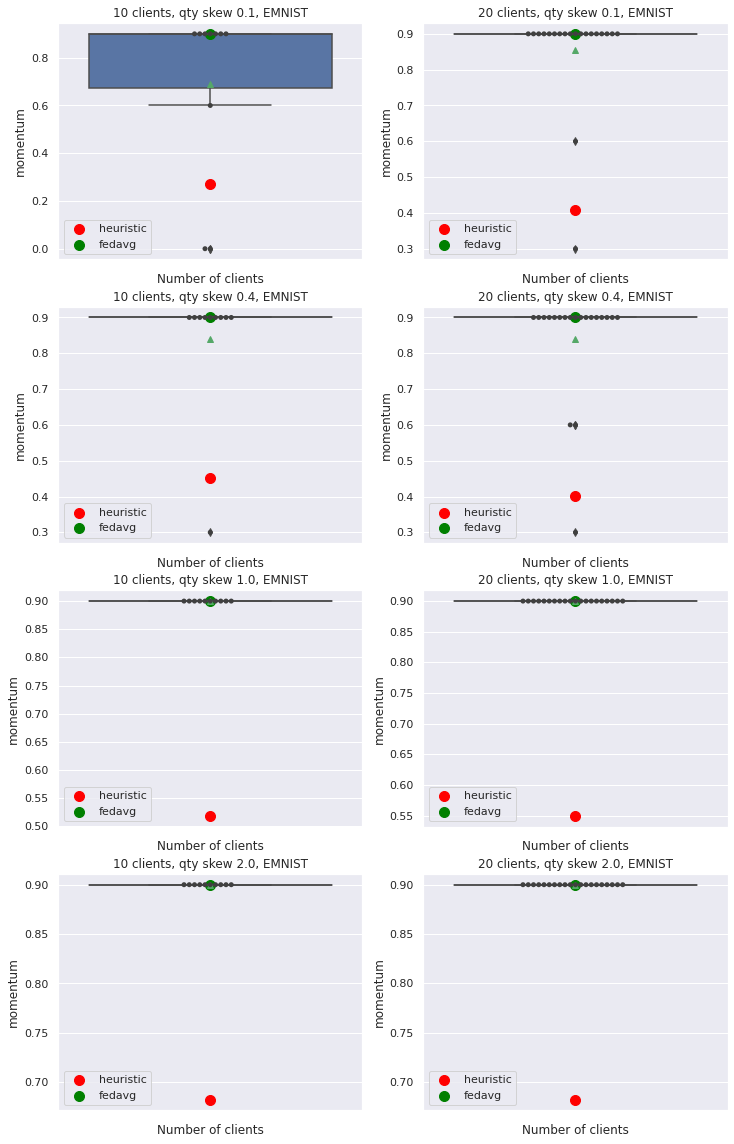

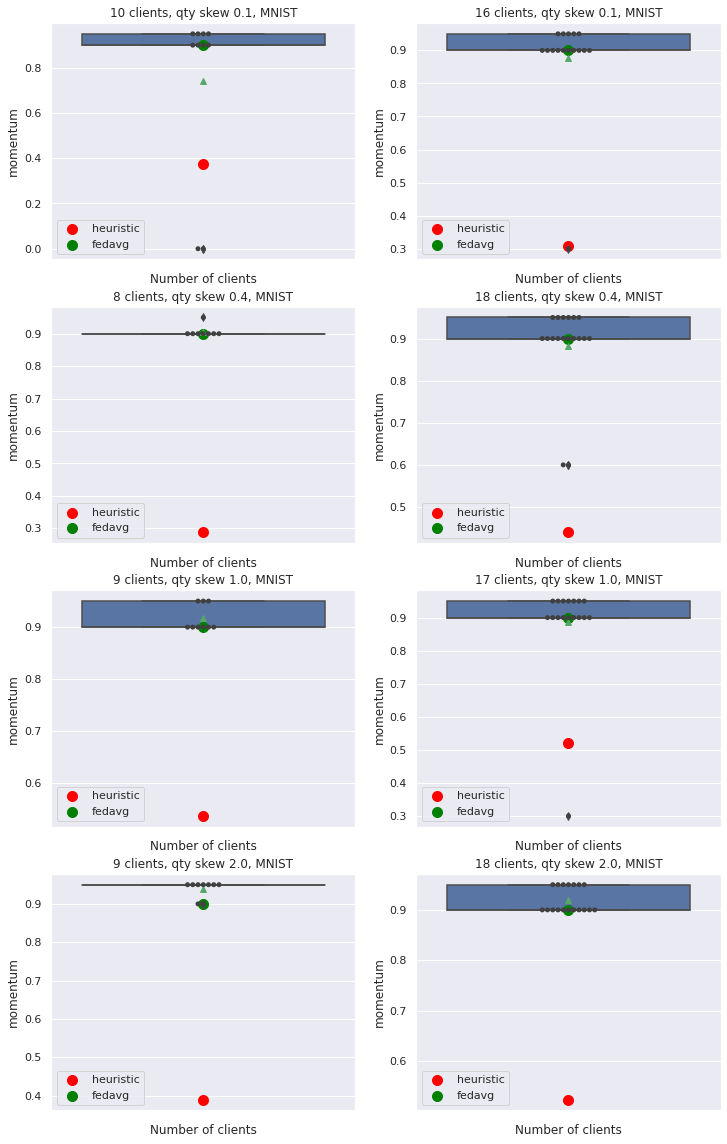

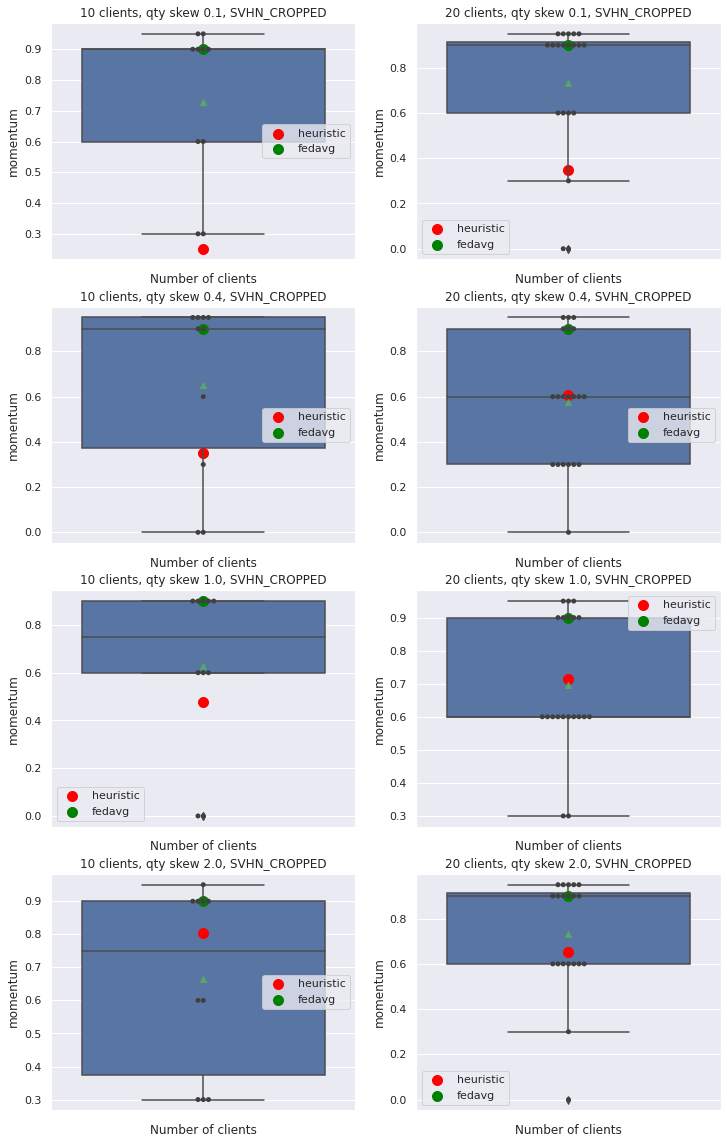

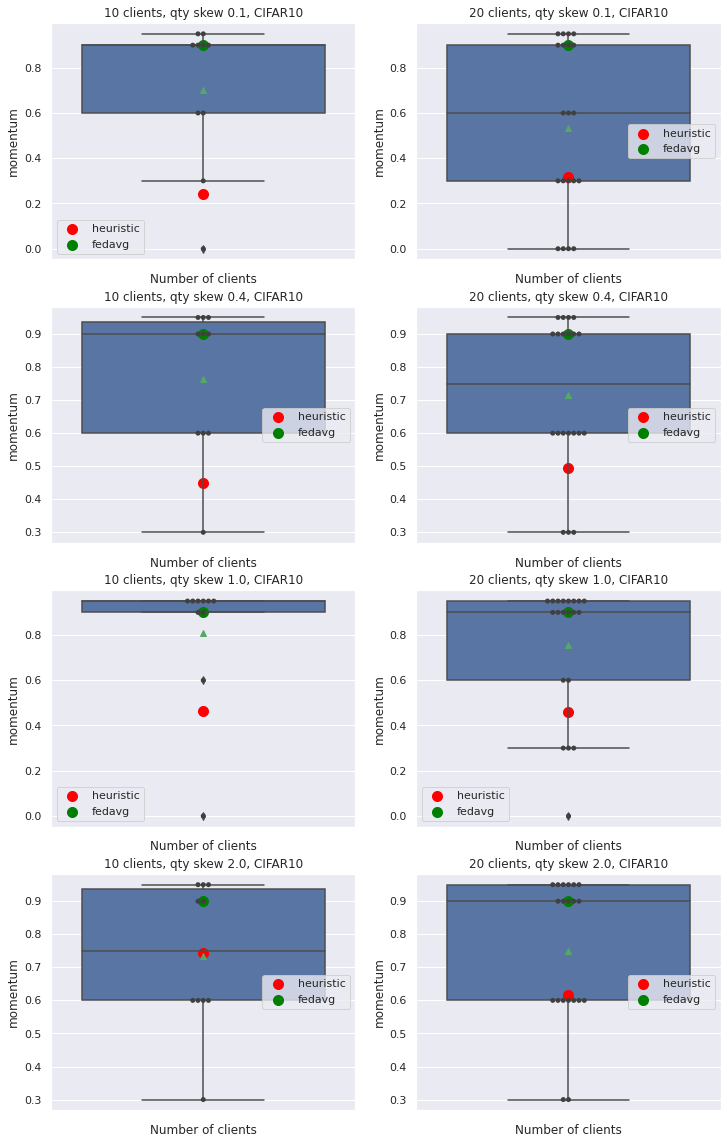

In [27]:
mom_qty_heuristic_aes = {}
mom_qty_baseline_aes = {}

for d in DATASETS:
    heuristic_aes, baseline_aes = plot_results(d, QTY_SKEWS, NR_PARTIES, "momentum", "qty")
    mom_qty_heuristic_aes = sum_dicts(mom_qty_heuristic_aes, heuristic_aes)
    mom_qty_baseline_aes = sum_dicts(mom_qty_baseline_aes, baseline_aes)

In [28]:
for v in ['v0', 'v1']:
    print(f"Heuristic {v} MAE: {np.mean(mom_qty_heuristic_aes[v]):.3f} ± {np.std(mom_qty_heuristic_aes[v]):.3f}")
print(f"Mean MAE: {np.mean(mom_qty_baseline_aes['mean']):.3f} ± {np.std(mom_qty_baseline_aes['mean']):.3f}")
print(f"Median MAE: {np.mean(mom_qty_baseline_aes['median']):.3f} ± {np.std(mom_qty_baseline_aes['median']):.3f}")

Heuristic v0 MAE: 0.421 ± 0.148
Heuristic v1 MAE: 0.255 ± 0.259
Mean MAE: 0.122 ± 0.102
Median MAE: 0.050 ± 0.094


Comments:
- Momentum heuristic tends to underestimate.
- Median baseline performs best, considerably better than heuristic.